# EDA of Chatbot Arena Dataset -- Starter Notebook

This notebook aims to help you explore the Chatbot Arena dataset, where two chatbots answer human questions, and users vote on the best response. Through this EDA, we will:
- Understand the dataset structure and contents.
- Explore the distribution of questions, responses, and chatbots.
- Identify patterns in the data to guide future modeling tasks.

## 1. Understanding the Dataset
The source dataset comes from https://huggingface.co/datasets/lmsys/chatbot_arena_conversations. The author describes the dataset as follows:

> This dataset contains 33K cleaned conversations with pairwise human preferences. It is collected from 13K unique IP addresses on the Chatbot Arena from April to June 2023. Each sample includes a question ID, two model names, their full conversation text in OpenAI API JSON format, the user vote, the anonymized user ID, the detected language tag, the OpenAI moderation API tag, the additional toxic tag, and the timestamp.

[Chatbot Arena](https://chat.lmsys.org/) is a platform where users can ask questions and two chatbots will provide answers. The user then votes on which chatbot provided the best answer. The dataset contains the questions, the answers, and the user votes.

### Main Dataset

- **Conversation Data**
You can find the processed dataset in `./chatbot-arena-conversations.jsonl.gz`. The dataset is in JSON line format and compressed using gzip. It has gone through the following preprocessing steps to make analysis easier:

    - Removed non-English conversations.
    - Removed conversations with more than one round.
    - Removed conversations classified as toxic or harmful.

The dataset you will be working with contains `25282` rows (out of `33000` total rows) and `7` columns. The columns are:

- `question_id`: A unique identifier for the question.
- `model_a`: The name of the first chatbot model.
- `model_b`: The name of the second chatbot model.
- `winner`: The name of the chatbot model that won the user vote.
- `judge`: The anonymized user ID that voted.
- `conversation_a`: The conversation between the user and `model_a`.
- `conversation_b`: The conversation between the user and `model_b`.

An example of the data is as follows:

```json
{
  "question_id": "c0fc42c6f5f14f2aa5a89f71f8553730",
  "model_a": "vicuna-13b",
  "model_b": "koala-13b",
  "winner": "model_a",
  "judge": "arena_user_973",
  "conversation_a": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10\n\nCounting with a step of 3 means that you will increase the number by 3 each time. So, the first number is 1, the next is 4 (1 + 3), the next is 7 (4 + 3), and so on.",
      "role": "assistant"
    }
  ],
  "conversation_b": [
    {
      "content": "Count from 1 to 10 with step = 3",
      "role": "user"
    },
    {
      "content": "1, 4, 7, 10",
      "role": "assistant"
    }
  ]
}
```

### Auxiliary Datasets

There are four auxiliary datasets that you can use to help with your analysis:

- **Embedding Data**
    - `./chatbot-arena-prompts-embeddings.npy` contains the 256-dimensional text embeddings for each of the human questions. The embeddings are generated using OpenAI’s text-embedding model. We will explain what embeddings are and how you can use them later.
    - `./chatbot-arena-model_a_response-embeddings.npy` contains the 256-dimensional text embeddings for each of the model a responses (second half of conversation a). The embeddings are generated using OpenAI’s text-embedding model.
     - `./chatbot-arena-model_b_response-embeddings.npy` contains the 256-dimensional text embeddings for each of of the model b responses (second half of conversation b). The embeddings are generated using OpenAI’s text-embedding model.

- **Topic Modeling and Hardness Score Data**
- `./chatbot-arena-gpt3-scores.jsonl.gz` ([example row](https://gist.github.com/simon-mo/25c5d532bccc7f28b404cffdfe719e6e#file-example-aux-row-json))
 contains labels for the dataset, which you can use for later modeling tasks. It has the following fields:
  - **question_id**: The unique identifier for the question, as seen in `./chatbot-arena-conversations.jsonl.gz`.
  - **prompt**: The extracted human question. This is equivalent to the first message in `conversation_a` and `conversation_b` in `./chatbot-arena-conversations.jsonl.gz`.
  - **openai_scores_raw_choices_nested**: The response from OpenAI GPT 3.5 model. It contains:
    - The evaluated topic model
    - The reason for a hardness score (from 1 to 10)
    - The score value

  For each prompt, we have 3 responses from GPT 3.5 because it is a probabilistic model. In the real world, multiple annotators may provide different labels for ground truth data. We extracted the following fields into columns:

  - **topic_modeling_1, topic_modeling_2, topic_modeling_3**: Topic modeling for the first, second, and third response. Each topic contains two words.
  - **score_reason_1, score_reason_2, score_reason_3**: The reasons for the hardness score for the first, second, and third response.
  - **score_value_1, score_value_2, score_value_3**: The hardness score for the first, second, and third response.

```json
{
  "question_id": "58210e39b3fd4441a2bd4a518bb44c2d",
  "prompt": "What is the difference between OpenCL and CUDA?",
  "openai_scores_raw_choices_nested": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Technical Comparison\",\n    \"score_reason\": \"This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 1,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Software Comparison\",\n    \"score_reason\": \"This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.\",\n    \"score_value\": 8\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    },
    {
      "finish_reason": "stop",
      "index": 2,
      "logprobs": null,
      "message": {
        "content": "{\n    \"topic_modeling\": \"Comparison, Technology\",\n    \"score_reason\": \"This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.\",\n    \"score_value\": 9\n}",
        "role": "assistant",
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "topic_modeling_1": "Technical Comparison",
  "score_reason_1": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI's factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",
  "score_value_1": 9,
  "topic_modeling_2": "Software Comparison",
  "score_reason_2": "This prompt assesses the AI's factual accuracy in distinguishing between two similar but distinct software frameworks.",
  "score_value_2": 8,
  "topic_modeling_3": "Comparison, Technology",
  "score_reason_3": "This prompt requires the AI to demonstrate knowledge of two different technologies, compare their features, and explain their distinctions. This task assesses the AI's factual accuracy and proficiency in understanding complex technological concepts.",
  "score_value_3": 9
}
```

## 2. Loading the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [ ]:
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section

df = pd.read_json(
    "chatbot-arena-conversations.jsonl.gz",
    compression="gzip",
    lines=True)
df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  
0  [{'content': 'What is the difference between O...  
1  [{'content': 'Why did my parent not invite me ...  
2  [{'content': 'Fuji vs. Nikon, which is better?...  
3  [{'content': 'How to build an arena for chatbo...  
4  [{'content': 'When is it today?', 'role': 'use...

In [ ]:
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

## 3. Exploring the Data

### Converstation Data

Let's investigate the conversation data first (`chatbot-arena-conversations.jsonl.gz`). It is in JSON line format, compressed with `gzip`. You can load the data with `pd.read_json`.

Before diving into any analysis, it's important to understand the structure of the dataset. In this section, we'll check the basic details of the data, such as the number of rows, column names, data types, and any missing values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25282 entries, 0 to 25281
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     25282 non-null  object
 1   model_a         25282 non-null  object
 2   model_b         25282 non-null  object
 3   winner          25282 non-null  object
 4   judge           25282 non-null  object
 5   conversation_a  25282 non-null  object
 6   conversation_b  25282 non-null  object
dtypes: object(7)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

As an example to guide you through the exploratory process, let’s investigate the length distribution of the prompt. This helps answer questions like (this is related to the ``Distribution of the prompt and response length'' requirement of the EDA assingment).
:

- Do the arena users ask long or short questions?
- What is the average length of prompts that users give to the chatbots?

By analyzing the length of the prompts, you can start forming hypotheses about how the length might affect model performance or user votes. This example will guide you in asking similar questions about other aspects of the dataset.

## Answers
1. The arena users ask a range in the length of prompt. Most users will ask shorter questions as the distribution of the prompt length is severly right skewed and shows us that the majority of students will ask shorter questions.  
2. The average length of the prompts that users will give to the chatbots is 196.7

In [ ]:
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)
df["prompt"].value_counts()

prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                               33
Sally (a girl) has 3 brothers. Each brother has 2 sisters. How many sisters does sally have?                                                                                                                                                                                                                                                                                                                                                               26
She felt something and likes me but loves other man. She lied about it for a month, treated me like junk, but then started to become warmer and then said that we should stop communicating because she is betraying another man when becoming closer to me. I said that we can just talk and it will be ok. She agreed. Then we talked some days, she became indifferent, I got angry and blocked her everywhere. Was it smart move or I just gave up?    25
Goal:\n\nCreate a prompt able to generate the given document. You will receive the given document page after page, and wait for the last page to create the prompt. Until the last page is sent, you will only answer [continuing]. When ready to receive the first page, only answer [ready].\n                                                                                                                                                           23
Write a single # character                                                                                                                                                                                                                                                                                                                                                                                                                                 22
                                                                                                                                                                                                                                                                                                                                                                                                                                                           ..
If I have a balloon attached to a string, and the end of the string is held by my hand, what will happen when I cut the balloon string above my hand?                                                                                                                                                                                                                                                                                                       1
What are some arguments used by flat-earthers to sustain their argument?                                                                                                                                                                                                                                                                                                                                                                                    1
Write a poem about sushi. Write as Mark Twen                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count    25282.00000
mean       196.74646
std        369.05595
min         16.00000
25%         42.00000
50%         72.00000
75%        156.00000
max       2560.00000
Name: prompt_length, dtype: float64

Looks like the mean length of the prompt is about **200 characters, while the median is 72 characters**. This suggests that the distribution is **right-skewed!** Let's visualize this.

<Axes: xlabel='prompt_length', ylabel='Count'>

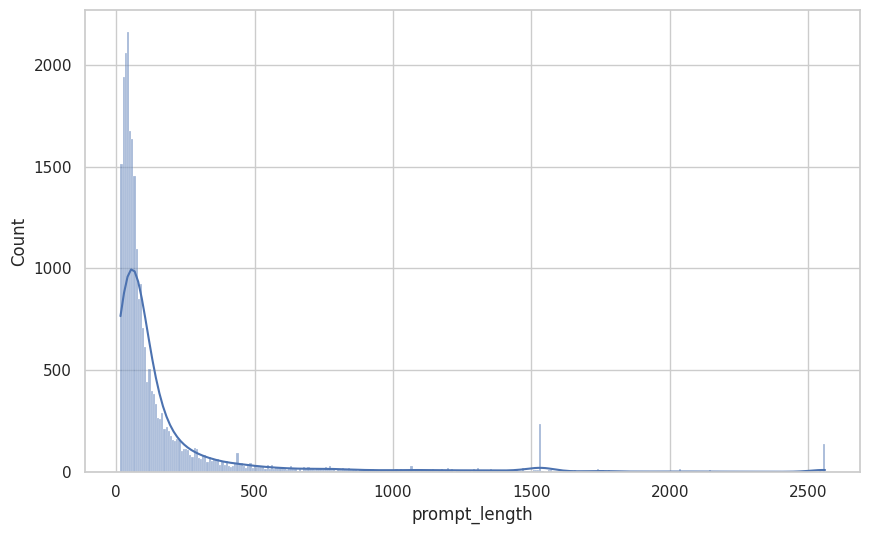

In [ ]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(df["prompt_length"], kde=True)

Now, can you apply the same thought process to visualize the distribution of the response length?

Applying the same logic you used to make the `prompt` column, you should also make the columns `model_a_response` and `model_b_response` by extracting the **second half** of the content from `conversation_a` and `conversation_b` respectively in order to look into specific content of the model responses.

### Embedding Data

Text embedding models transform natural language text into numerical vectors. The vectors are generated in such a way that semantically similar text are close to each other in the vector space. In the real world, these embeddings to find similar questions or to cluster the questions.

Concretely, the auxiliary dataset,`./chatbot-arena-prompts-embeddings.npy`, `./chatbot-arena-model_a_response-embeddings.npy`, and `./chatbot-arena-model_b_response-embeddings.npy`, contains 256-dimensional text embeddings for each of the human questions, model a responses and model b responses respectively.

In this section, we will walk you through an example of computing the similarity between prompts using the precomputed embeddings (`./chatbot-arena-prompts-embeddings.npy`). The goal is to find prompts that are most similar to a given prompt based on their embeddings.

Before we get started, let's first load and output the `propmt_embeddings` which we have loaded in the second section to see what they look like. Each embedding is a 256-dimensional vector that represents the semantic meaning of a prompt. These vectors allow us to compare prompts based on their content.

In [ ]:
prompt_embeddings

array([[-0.12376316, -0.1173524 ,  0.04567662, ..., -0.02439648,
        -0.03724024, -0.04380682],
       [ 0.00602781,  0.02843601, -0.09102212, ...,  0.08506154,
        -0.05333152,  0.00185428],
       [-0.03522179, -0.10940242, -0.02224718, ..., -0.14116742,
         0.00477351,  0.00416916],
       ...,
       [ 0.02476096, -0.02741823,  0.07049022, ..., -0.05541623,
        -0.02461602,  0.06005438],
       [ 0.01620374,  0.04473886,  0.08496623, ..., -0.02189322,
        -0.05438842,  0.02849752],
       [-0.04179214,  0.00963908, -0.00338678, ...,  0.08221702,
        -0.02381286, -0.10591594]], dtype=float32)

The embeddings are a matrix where each row corresponds to a prompt from the dataset. Each row is a 256-dimensional vector that captures the semantic meaning of the prompt.

In [ ]:
prompt_embeddings.shape

(25282, 256)

The embeddings array has a shape of `(25282, 256)`, meaning there are 25,282 embeddings (one for each prompt), and each embedding is a 256-dimensional vector.

Next, we will:
1. Take a sample of the embeddings to reduce computation time.
2. Compute the dot product between the embeddings to measure similarity.
3. Retrieve the most similar prompts to a chosen source prompt.
4. Output the top 5 similar prompts.
(This is related to the ``(Open-ended) Explore the prompt topics in the dataset (topic modeling).'' requirement of the EDA assignment)

Start by taking a sample of the embeddings and calculating the similarity between them using the dot product.

In [ ]:
# Let's try to find the closest prompt to a given prompt
embeddings_sample = prompt_embeddings[:1000]

# Compute the dot product between the embeddings
dot_product = np.dot(embeddings_sample, embeddings_sample.T)
dot_product.shape

(1000, 1000)

Given the above output, the dot product matrix has a shape of (1000, 1000), meaning we have similarity scores between all pairs of prompts in our sample of 1000.

Next, let's choose a prompt and find the top 5 most similar prompts based on the computed similarity.

In [ ]:
source_prompt_idx = 23
source_prompt = df.iloc[source_prompt_idx].prompt
source_prompt

'Write me a function to lazily compute a Fibonacci sequence in Clojure. '

The prompt we're using as a reference (index 23) is:

`'Write me a function to lazily compute a Fibonacci sequence in Clojure.'`

Now let's find the top 5 most similar prompts to this one.

In [ ]:
top_k = 5
similar_promts_idx = np.argsort(dot_product[source_prompt_idx])[-top_k:][::-1]
similar_promts = df.iloc[similar_promts_idx].prompt
similar_promts.tolist()

['Write me a function to lazily compute a Fibonacci sequence in Clojure. ',
 "Let's write a function that sums every third number from 1 to 100.",
 'Write an efficient Fibonacci number calculator in Python. ',
 'Write a program in Ocaml to compute the square root of a number.',
 'What is a pure function?']

As you can see, these prompts are closely related to programming tasks, many of them dealing with functions and computations. This shows how embeddings can group semantically similar questions together.

You also have the embeddings for responses from models a (`./chatbot-arena-model_a_response-embeddings.npy`) and model b (`./chatbot-arena-model_b_response-embeddings.npy`) respectively to explore. (These are the embeddings from columns `model_a_response` and `model_b_response` which can be created by extracting the second half of columns `conversation_a` and `conversation_b` respectively (as explained in the previous section).

Potential follow-up questions you can explore:
- Can you identify clusters of similar topics within the dataset?
- How do different models perform on similar prompts?
- Can you find examples where semantically similar prompts result in different outcomes?

### Topic Modeling and Hardness Score Data

Now, let's explore the second auxiliary dataset `./chatbot-arena-gpt3-scores.jsonl.gz`, which contains valuable information for later modeling tasks.

For each prompt, there are 3 responses, as GPT-3.5 is probabilistic. This means we get multiple labels for a single prompt, similar to how real-world datasets can have multiple annotations.

Let's start by loading and inspecting the first 5 rows of this dataset to understand its structure.

**_Warning_: This data can be messy! This is intentionally not cleaned up for you to resemble real-world data. You are responsible for figuring out the irregularities and cleaning it up. The following cells demonstrate the example of messy data.**

In [ ]:
topic_and_hardness.head(5)

question_id  \
0  58210e39b3fd4441a2bd4a518bb44c2d   
1  2564acd09e3942fd97657d05282d4389   
2  90bfd142157948aba01931726c888e7f   
3  a7c5accc53e649a3bc6b2e41d962ebc4   
4  adf27e819a3c494cb6e993f0c660e097   

                                              prompt  \
0    What is the difference between OpenCL and CUDA?   
1  Why did my parent not invite me to their wedding?   
2                   Fuji vs. Nikon, which is better?   
3                How to build an arena for chatbots?   
4                                  When is it today?   

                    openai_scores_raw_choices_nested      topic_modeling_1  \
0  [{'finish_reason': 'stop', 'index': 0, 'logpro...  Technical Comparison   
1  [{'finish_reason': 'stop', 'index': 0, 'logpro...    Reasoning, Emotion   
2  [{'finish_reason': 'stop', 'index': 0, 'logpro...     Camera comparison   
3  [{'finish_reason': 'stop', 'index': 0, 'logpro...         Chatbot Arena   
4  [{'finish_reason': 'stop', 'index': 0, 'logpro...            Time Query   

                                      score_reason_1 score_value_1  \
0  This prompt requires the AI to accurately comp...             9   
1  This prompt requires the AI to understand huma...             9   
2  This prompt does not require problem-solving s...             2   
3  This prompt requires problem-solving skills an...             8   
4  This prompt is very straightforward and does n...             2   

          topic_modeling_2                                     score_reason_2  \
0      Software Comparison  This prompt assesses the AI's factual accuracy...   
1  Emotions, Relationships  This prompt involves understanding complex hum...   
2     Comparative Analysis  This prompt assesses the AI's ability to analy...   
3            Chatbot Arena  This prompt requires the AI to engage in probl...   
4             Date Inquiry  This prompt is very straightforward and does n...   

  score_value_2        topic_modeling_3  \
0             8  Comparison, Technology   
1             8    Reasoning, Emotional   
2             6  Photography comparison   
3             8           Chatbot Arena   
4             2      Time-based Inquiry   

                                      score_reason_3 score_value_3  
0  This prompt requires the AI to demonstrate kno...             9  
1  This prompt challenges the AI to infer motives...             8  
2  This prompt is subjective and does not provide...             2  
3  This prompt requires problem-solving skills an...             8  
4  This prompt is too straightforward and simply ...             2

**Understand the Structure**
How are the topic modeling and hardness scores structured across the dataset?
- Look at the columns `topic_modeling_1`, `score_reason_1`, `score_value_1`, etc.
- How consistent are the values across the rows? Do they follow a pattern? Are there any irregularities or unexpected values?

**Data Cleaning**
The following are some of the things (many) you should explore to clean your data:
- Are there any missing values?
- The data in the `openai_scores_raw_choices_nested` field appears messy. It contains a list of nested dictionaries that might need to be flattened for easier analysis. Consider these points:
    - Do you need all the nested data? Perhaps you only need the final hardness scores and topic modeling results for your analysis.
    - One way to deal with the nested openai_scores_raw_choices_nested field is to flatten it into more readable columns if you find you need the nested data.
- Sometimes, there could be repeated entries in the dataset. Make sure that each question (question_id) and its corresponding responses are unique.

Let’s begin by checking for missing values in our dataset.

In [ ]:
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    26
score_reason_1                      26
score_value_1                       26
topic_modeling_2                    26
score_reason_2                      26
score_value_2                       26
topic_modeling_3                    26
score_reason_3                      26
score_value_3                       26
dtype: int64

What are some strategies for handling missing values?

Messy data is not only about missing values, it can also be about inconsistent formatting. Let's check for inconsistencies in the `score_value_1` column of the dataset. The `score_value_1` field should contain numerical values representing hardness scores. However, sometimes data can be messy, and we might encounter values that are not in the expected format (e.g., lists instead of single numbers).

The code below demonstrates how to identify rows where `score_value_1` is incorrectly formatted as a list:

In [ ]:
topic_and_hardness["score_value_1"][
    topic_and_hardness["score_value_1"].apply(lambda x: isinstance(x, list))
].head()

12     [[8]]
48     [[7]]
86     [[7]]
144    [[8]]
181    [[7]]
Name: score_value_1, dtype: object

Why do you think `score_value_1` contains lists instead of single values? What might have caused this? What steps would you take to fix this issue so that `score_value_1` contains only numeric values? Are there any other columns that might have similar issues?

Once you clean the dataset, you can start your analysis by think about the following questions:
- Do models perform differently based on hardness scores?
- What are the most common topics in the dataset?
- Which topics tend to have higher hardness scores?

## Summary and Next Steps

You've now explored various aspects of the dataset, including prompt lengths, response lengths, and embeddings, as well as handling messy data. As you proceed, it's important to remember the key **EDA requirements** for this milestone:

1. **Ranking of the model based on their win rate or ELO ratings**
2. **Distribution of the prompt and response length**
4. **Hardness score distribution and its correlation with the models**
5. **Open-ended: Visualize the "variance" in model performance**
6. **Open-ended: Explore the prompt topics in the dataset (topic modeling)**

### What Have You Discovered?

Now that you've completed the initial exploration through this notebook, think about the following:

- **Which insights surprised you?**  
- **What further questions would you ask based on the patterns you've seen?**  
- **Which analyses are still missing or could be extended?**

This notebook provides a foundation for your EDA, but the real insights will come from the questions you ask and the deeper analyses you conduct. Use this notebook as a starting point to explore relationships in the data that will help inform your understanding of chatbot performance. By formulating and answering your questions as a team, you'll gain a richer understanding of the dataset and get ready for the modeling tasks.

## Data Structuring

#### Establishing a "winner" column to display the outcome of the competition between model a and model b.

In [ ]:
#add a new column that displays the name of the winning chatbot model (or tie)
df['winner_name'] = np.where(
    df['winner'] == 'model_a', df['model_a'],
    np.where(
        df['winner'] == 'model_b', df['model_b'],
        np.where(
            df['winner'] == 'tie(bothbad)', 'tie(bothbad)',
            df['model_a'] + ' & ' + df['model_b']))
)
df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  
0                      koala-13b  
1  oasst-pythia-12b & alpaca-13b  
2               oasst-pythia-12b  
3               oasst-pythia-12b  
4                     vicuna-13b

One hot encodings for "winner" column

In [ ]:
#create one-hot encodings for the winning chatbot model
#this will attribute a value of 1 to the model if that model wins or there is a tie(bothgood) otherwise it gives it a 0
#there were around 20 chatbots so i think it might be too chaotic to do this for individual chatbots
df['one_hot_a'] = np.where(
    (df['winner'] == 'model_a') | (df['winner'] == 'tie'), 1, 0)

df['one_hot_b'] = np.where(
    (df['winner'] == 'model_b') | (df['winner'] == 'tie'), 1, 0)
df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  one_hot_a  one_hot_b  
0                      koala-13b          0          1  
1  oasst-pythia-12b & alpaca-13b          1          1  
2               oasst-pythia-12b          0          1  
3               oasst-pythia-12b          0          1  
4                     vicuna-13b          1          0

#### Establishing columns to separate the prompt and responses from the conversations

In [ ]:
#add columns to separate responses from the conversation (we already did this for the prompt)
df["model_a_response"] = df["conversation_a"].str[1].str["content"]
df["model_b_response"] = df["conversation_b"].str[1].str["content"]
df["model_a_response"][2]

'Both Fuji and Nikon are popular camera brands that offer a wide range of cameras for different types of photography. It really depends on your specific needs and preferences as to which brand is "better" for you.\n\nFujifilm is known for its high image quality, especially in the areas of color accuracy and dynamic range. Many photographers also appreciate the company\'s focus on ergonomics and the overall user experience of its cameras. Additionally, Fujifilm has a loyal following among enthusiasts and professional photographers, thanks to its commitment to film photography and its high-end mirrorless cameras.\n\nNikon, on the other hand, is known for its advanced autofocus system and image stabilization technology, as well as its high-end cameras and lenses. Nikon also has a wide selection of cameras and lenses to choose from, including both DSLR and mirrorless options.\n\nUltimately, it\'s difficult to say which brand is "better" without knowing more about your specific needs and pr

Establishing columns for lengths of prompt and responses

In [ ]:
#create columns for prompt and response lengths
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe() #use this if you want to know statistics about prompt and response lengths

df["response_a_length"] = df["model_a_response"].str.len()


df["response_b_length"] = df["model_b_response"].str.len()


#### In the cell below, each chat bot is assigned to a numerical value and established in the column "winner_name_id"

In [ ]:
#assigns a numerical value to the name of the winning chatbot
#this might be helpful for one hot encodings - if not we can take it out later

#create function to assign numerical values to unique names
def unique_name_ids(names):
    # Create an empty list to store unique names
    unique_names = set()

    # Split names at the & and strip whitespace
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        unique_names.update(parts)  # Add unique parts to the set

    # map names to unique id numbers
    name_to_id = {name: idx for idx, name in enumerate(unique_names)}

    # store list of ids and names
    ids = []
    for name in names:
        parts = [part.strip() for part in name.split('&')]
        name_ids = [name_to_id[part] for part in parts]
        ids.append(name_ids)

    return ids

# Apply the function to create a new column
df['winner_name_id'] = unique_name_ids(df['winner_name'])

df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  one_hot_a  one_hot_b  \
0                      koala-13b          0          1   
1  oasst-pythia-12b & alpaca-13b          1          1   
2               oasst-pythia-12b          0          1   
3               oasst-pythia-12b          0          1   
4                     vicuna-13b          1          0   

                                    model_a_response  \
0  OpenCL and CUDA are two different programming ...   
1  It is possible that your parent did not invite...   
2  Both Fuji and Nikon are popular camera brands ...   
3  Building an arena for chatbots can be done by ...   
4  I'm sorry, I cannot determine the current date...   

                                    model_b_response  response_a_length  \
0  OpenCL and CUDA are both programming languages...                892   
1  It is likely that they wanted to keep the gues...                660   
2  This is a subjective question and the answer d...               1114   
3  Building an arena for chatbots is a great way ...               1575   
4                        Today is February 23, 2023.                267   

   response_b_length winner_name_id  
0               1905            [0]  
1                514        [14, 2]  
2               1566           [14]  
3               1624           [14]  
4                 27           [12]

### Engineering feature of dot product similarity between embeddings, before we filter - as filtering changed the indices order which messed up the embeddings files!

In [ ]:
assert len(prompt_embeddings) == len(df), "Mismatch between prompt embeddings and DataFrame rows."
assert len(response_a_embeddings) == len(df), "Mismatch between response_a embeddings and DataFrame rows."
assert len(response_b_embeddings) == len(df), "Mismatch between response_b embeddings and DataFrame rows."

# Compute dot products and add them as new columns to the original DataFrame
df['similarity_prompt_response_a'] = [
    np.dot(prompt, response_a)
    for prompt, response_a in zip(prompt_embeddings, response_a_embeddings)
]

df['similarity_prompt_response_b'] = [
    np.dot(prompt, response_b)
    for prompt, response_b in zip(prompt_embeddings, response_b_embeddings)
]

# Display the first few rows to verify the new columns
df.head()

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  one_hot_a  one_hot_b  \
0                      koala-13b          0          1   
1  oasst-pythia-12b & alpaca-13b          1          1   
2               oasst-pythia-12b          0          1   
3               oasst-pythia-12b          0          1   
4                     vicuna-13b          1          0   

                                    model_a_response  \
0  OpenCL and CUDA are two different programming ...   
1  It is possible that your parent did not invite...   
2  Both Fuji and Nikon are popular camera brands ...   
3  Building an arena for chatbots can be done by ...   
4  I'm sorry, I cannot determine the current date...   

                                    model_b_response  response_a_length  \
0  OpenCL and CUDA are both programming languages...                892   
1  It is likely that they wanted to keep the gues...                660   
2  This is a subjective question and the answer d...               1114   
3  Building an arena for chatbots is a great way ...               1575   
4                        Today is February 23, 2023.                267   

   response_b_length winner_name_id  similarity_prompt_response_a  \
0               1905            [0]                      0.751438   
1                514        [14, 2]                      0.751248   
2               1566           [14]                      0.815042   
3               1624           [14]                      0.829923   
4                 27           [12]                      0.364985   

   similarity_prompt_response_b  
0                      0.802665  
1                      0.502628  
2                      0.767400  
3                      0.826861  
4                      0.566376

#### Converting the score_value_"n" columns, in topic_and_hardness dataframe, to numeric values and stored in the column "hardness_score"

In [ ]:
#convert hardness scores from list to numeric
topic_and_hardness['score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness['score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness['score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

In [ ]:

topic_and_hardness.drop_duplicates(subset='question_id', inplace=True)

In [ ]:
#this will merge the mean value of the hardness scores and the topic_modeling 3 with the main data set
topic_and_hardness['hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)
merged_df = df.merge(topic_and_hardness[['question_id', 'hardness_score', 'topic_modeling_3']], on='question_id', how='left')
merged_df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  ...  one_hot_b  \
0                      koala-13b  ...          1   
1  oasst-pythia-12b & alpaca-13b  ...          1   
2               oasst-pythia-12b  ...          1   
3               oasst-pythia-12b  ...          1   
4                     vicuna-13b  ...          0   

                                    model_a_response  \
0  OpenCL and CUDA are two different programming ...   
1  It is possible that your parent did not invite...   
2  Both Fuji and Nikon are popular camera brands ...   
3  Building an arena for chatbots can be done by ...   
4  I'm sorry, I cannot determine the current date...   

                                    model_b_response response_a_length  \
0  OpenCL and CUDA are both programming languages...               892   
1  It is likely that they wanted to keep the gues...               660   
2  This is a subjective question and the answer d...              1114   
3  Building an arena for chatbots is a great way ...              1575   
4                        Today is February 23, 2023.               267   

   response_b_length  winner_name_id similarity_prompt_response_a  \
0               1905             [0]                     0.751438   
1                514         [14, 2]                     0.751248   
2               1566            [14]                     0.815042   
3               1624            [14]                     0.829923   
4                 27            [12]                     0.364985   

   similarity_prompt_response_b  hardness_score        topic_modeling_3  
0                      0.802665        8.666667  Comparison, Technology  
1                      0.502628        8.333333    Reasoning, Emotional  
2                      0.767400        3.333333  Photography comparison  
3                      0.826861        8.000000           Chatbot Arena  
4                      0.566376        2.000000      Time-based Inquiry  

[5 rows x 21 columns]

#### Removing question ids that produce null values and storing the final dataset into filtered_df

In [ ]:
# This will remove question ids that produced null values for topic_and_hardness
filtered_df = merged_df[
    ~merged_df['question_id'].isin([
        'e6d45ead33114cca8ee3cfa028517eff',
        'addaa796ee094f029f8014ea1468df8a',
        'd37eb99864fa41ecab49026abdddb53e',
        '6da02001e74041d0947982fb4d05db9e',
        'd93e36df73e84aa2ade15d4a038c098f',
        '50b63f92bc5948218e1555d1eae17797',
        '8277b16d9a0845d694a33c04f446926c',
        'd56d698d4c1c495682a366f2a78fcb77',
        '86c7abedb5f84b7ea752cc98d324d387',
        '974569d7b9c74ca591f1922bf3722266',
        'ba3cfbae941946c6a41ea725b46f3aa7',
        '283be8724d674cb6a74da59d0c12ea16',
        'fbd400babd914eb1ad6202b4400d6beb',
        '087b90bf76ed4c409b7c7bd5d6b0d6c5',
        'f9ad250d0194489b8b9f12d31386aab1',
        '7e371a23981847c7b19bc61195f11eda',
        'f55b273603754c0d92f5139351ca0d02',
        '255e1466eaf14cc2ba93040776c0c440',
        '6979b646271e46f4a329a5e6acaeed38',
        'ed7fa335d5524295b1dd79452778d26c',
        'f794c699e4964b11a1373976be5b0944',
        'c92bcab701cc46649368fc121b84ccc1',
        'a632607132cf4908883fd262102714c9',
        'a0857d64b4954ea6bd75c2406c3dd32c',
        'e4a1fc8a9462475d95022914cb9f5b03',
        'c7aa752f61dc46d093dc86713686f6f3'
    ])
]


In [ ]:
filtered_df.head(5)

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?             47   
1  Why did my parent not invite me to their wedding?             49   
2                   Fuji vs. Nikon, which is better?             32   
3                How to build an arena for chatbots?             35   
4                                  When is it today?             17   

                     winner_name  ...  one_hot_b  \
0                      koala-13b  ...          1   
1  oasst-pythia-12b & alpaca-13b  ...          1   
2               oasst-pythia-12b  ...          1   
3               oasst-pythia-12b  ...          1   
4                     vicuna-13b  ...          0   

                                    model_a_response  \
0  OpenCL and CUDA are two different programming ...   
1  It is possible that your parent did not invite...   
2  Both Fuji and Nikon are popular camera brands ...   
3  Building an arena for chatbots can be done by ...   
4  I'm sorry, I cannot determine the current date...   

                                    model_b_response response_a_length  \
0  OpenCL and CUDA are both programming languages...               892   
1  It is likely that they wanted to keep the gues...               660   
2  This is a subjective question and the answer d...              1114   
3  Building an arena for chatbots is a great way ...              1575   
4                        Today is February 23, 2023.               267   

   response_b_length  winner_name_id similarity_prompt_response_a  \
0               1905             [0]                     0.751438   
1                514         [14, 2]                     0.751248   
2               1566            [14]                     0.815042   
3               1624            [14]                     0.829923   
4                 27            [12]                     0.364985   

   similarity_prompt_response_b  hardness_score        topic_modeling_3  
0                      0.802665        8.666667  Comparison, Technology  
1                      0.502628        8.333333    Reasoning, Emotional  
2                      0.767400        3.333333  Photography comparison  
3                      0.826861        8.000000           Chatbot Arena  
4                      0.566376        2.000000      Time-based Inquiry  

[5 rows x 21 columns]

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25256 entries, 0 to 25281
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   question_id                   25256 non-null  object 
 1   model_a                       25256 non-null  object 
 2   model_b                       25256 non-null  object 
 3   winner                        25256 non-null  object 
 4   judge                         25256 non-null  object 
 5   conversation_a                25256 non-null  object 
 6   conversation_b                25256 non-null  object 
 7   prompt                        25256 non-null  object 
 8   prompt_length                 25256 non-null  int64  
 9   winner_name                   25256 non-null  object 
 10  one_hot_a                     25256 non-null  int64  
 11  one_hot_b                     25256 non-null  int64  
 12  model_a_response              25256 non-null  object 
 13  model_

## Ranking of the model based on their win rate or ELO ratings

#### Calculating the win rate per model:

<ipython-input-114-465fa5e1bdbc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["win_model_a"] = filtered_df.apply(lambda row: 1 if row["winner"] == "tie" else (1 if row["winner"] == "model_a" else 0), axis=1)
<ipython-input-114-465fa5e1bdbc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["win_model_b"] = filtered_df.apply(lambda row: 1 if row["winner"] == "tie" else (1 if row["winner"] == "model_b" else 0), axis=1)
<ipython-input-114-465fa5e1bdbc>:6: SettingWithCopyWarning: 
A v

win rates per model:
model
gpt-4                      0.819597
claude-v1                  0.740222
claude-instant-v1          0.699353
gpt-3.5-turbo              0.683232
vicuna-13b                 0.579462
palm-2                     0.551101
guanaco-33b                0.531830
wizardlm-13b               0.498807
koala-13b                  0.470991
vicuna-7b                  0.431299
mpt-7b-chat                0.338858
gpt4all-13b-snoozy         0.331117
oasst-pythia-12b           0.328923
RWKV-4-Raven-14B           0.325722
alpaca-13b                 0.324284
chatglm-6b                 0.283476
fastchat-t5-3b             0.282477
stablelm-tuned-alpha-7b    0.251619
dolly-v2-12b               0.210602
llama-13b                  0.206092
Name: win, dtype: float64


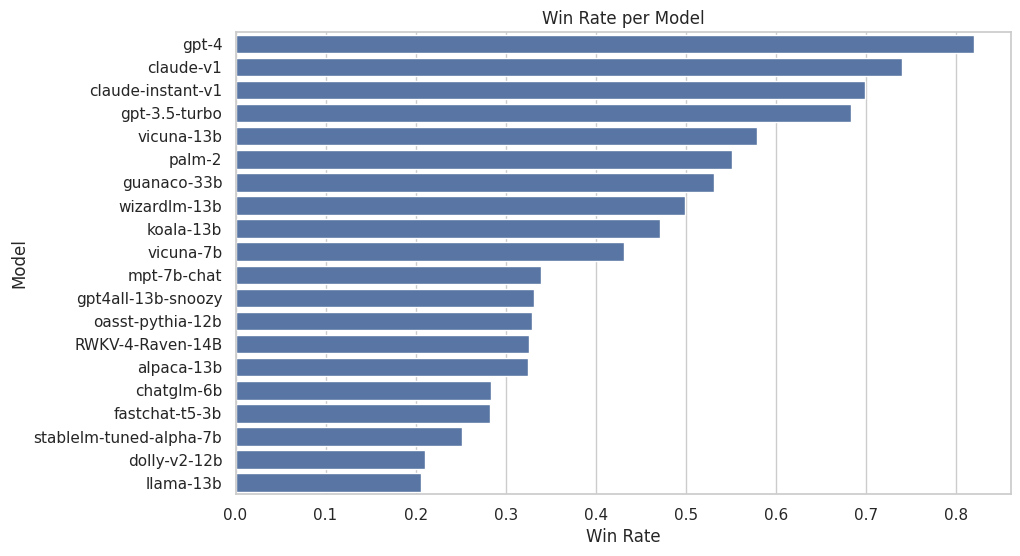

In [ ]:
# binary indicators for models
filtered_df["win_model_a"] = filtered_df.apply(lambda row: 1 if row["winner"] == "tie" else (1 if row["winner"] == "model_a" else 0), axis=1)
filtered_df["win_model_b"] = filtered_df.apply(lambda row: 1 if row["winner"] == "tie" else (1 if row["winner"] == "model_b" else 0), axis=1)

# exclude bad ties
filtered_df["win_model_a"] = filtered_df.apply(lambda row: 0 if row["winner"] == "tie (bothbad)" else row["win_model_a"], axis=1)
filtered_df["win_model_b"] = filtered_df.apply(lambda row: 0 if row["winner"] == "tie (bothbad)" else row["win_model_b"], axis=1)

# dataframe
model_wins = pd.concat([
    filtered_df[["model_a", "win_model_a"]].rename(columns={"model_a": "model", "win_model_a": "win"}),
    filtered_df[["model_b", "win_model_b"]].rename(columns={"model_b": "model", "win_model_b": "win"})
])

# Calculate win rate for each model
win_rates = model_wins.groupby("model")["win"].mean().sort_values(ascending=False)
print("win rates per model:")
print(win_rates)

# Plot win rates
plt.figure(figsize=(10, 6))
sns.barplot(x=win_rates.values, y=win_rates.index)
plt.title("Win Rate per Model")
plt.xlabel("Win Rate")
plt.ylabel("Model")
plt.show()


### Create column where the ELO ratings are compared, model a minus model b, to give a measure of which model is stronger so that we can include the prompt features as well in task A (predicting whether model a or model b will win)

In [ ]:
filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(
    lambda row: elo_ratings[row['model_a']] - elo_ratings[row['model_b']],
    axis=1
)

# Display the first few rows to verify the new column
filtered_df.columns

<ipython-input-115-3bdfac2b4e9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['elo_modela_minus_modelb'] = filtered_df.apply(


Index(['question_id', 'model_a', 'model_b', 'winner', 'judge',
       'conversation_a', 'conversation_b', 'prompt', 'prompt_length',
       'winner_name', 'one_hot_a', 'one_hot_b', 'model_a_response',
       'model_b_response', 'response_a_length', 'response_b_length',
       'winner_name_id', 'similarity_prompt_response_a',
       'similarity_prompt_response_b', 'hardness_score', 'topic_modeling_3',
       'win_model_a', 'win_model_b', 'elo_modela_minus_modelb'],
      dtype='object')

#### Calculating the ELO ratings per model:

ELO ratings per model:
                      model   ELO_rating
15        claude-instant-v1  1292.688016
10                    gpt-4  1250.726993
11                claude-v1  1234.758964
19              guanaco-33b  1124.567221
9             gpt-3.5-turbo  1110.799361
3                vicuna-13b  1109.473792
14                   palm-2  1074.086047
2                 koala-13b  1069.641717
16                vicuna-7b  1050.621375
17             wizardlm-13b   997.391029
13              mpt-7b-chat   969.416715
12         RWKV-4-Raven-14B   937.085978
5                alpaca-13b   928.131634
18       gpt4all-13b-snoozy   926.279119
0                chatglm-6b   889.066656
1          oasst-pythia-12b   884.891087
4   stablelm-tuned-alpha-7b   839.718473
8            fastchat-t5-3b   827.172397
6                 llama-13b   773.750292
7              dolly-v2-12b   709.733134


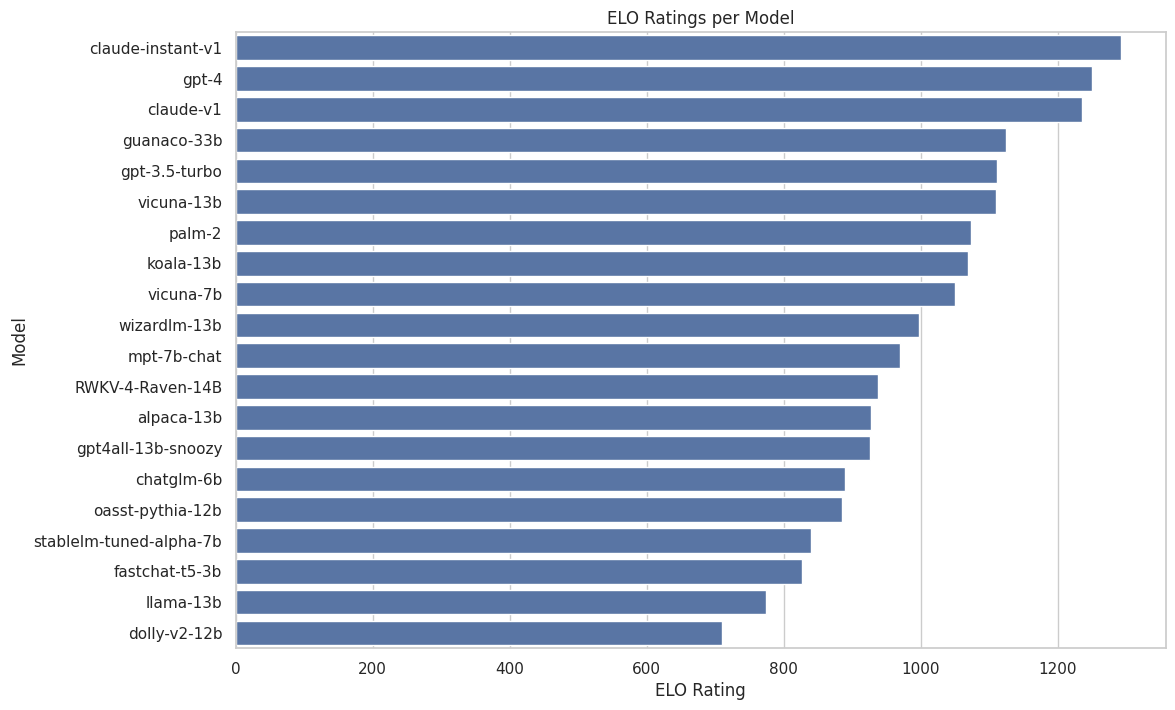

In [ ]:
# Initialize ratings dictionary with a default rating (e.g., 1000 for each model)
elo_ratings = {model: 1000 for model in pd.concat([filtered_df["model_a"], filtered_df["model_b"]]).unique()}

def update_elo(winner, loser, k=32):
    """Adjust the ELO rating based on the winner and loser models."""
    winner_rating = elo_ratings[winner]
    loser_rating = elo_ratings[loser]

    # expected scores
    expected_winner = 1 / (1 + 10 ** ((loser_rating - winner_rating) / 400))
    expected_loser = 1 - expected_winner

    # update ratings
    elo_ratings[winner] += k * (1 - expected_winner)
    elo_ratings[loser] += k * (0 - expected_loser)

# Loop over each row to adjust ELO ratings
for i, row in filtered_df.iterrows():
    if row["winner"] == "model_a":
        update_elo(row["model_a"], row["model_b"])
    elif row["winner"] == "model_b":
        update_elo(row["model_b"], row["model_a"])

# convert ELO ratings to a sorted DataFrame
elo_df = pd.DataFrame(list(elo_ratings.items()), columns=["model", "ELO_rating"]).sort_values(by="ELO_rating", ascending=False)
print("ELO ratings per model:")
print(elo_df)

# barplot
plt.figure(figsize=(12, 8))
sns.barplot(x=elo_df["ELO_rating"], y=elo_df["model"])
plt.title("ELO Ratings per Model")
plt.xlabel("ELO Rating")
plt.ylabel("Model")
plt.show()


## Distribution of length of prompt & responses

#### Visualizing length of the prompts

Text(0, 0.5, 'Frequency')

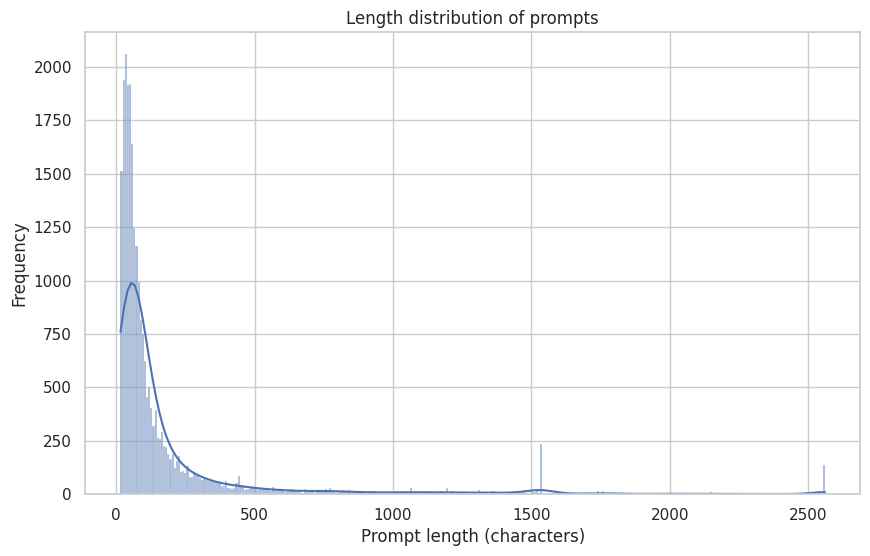

In [ ]:
# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["prompt_length"], kde=True)
plt.title("Length distribution of prompts")
plt.xlabel("Prompt length (characters)")
plt.ylabel("Frequency")

#### Length of unique prompts

In [ ]:
unique=df["prompt"].unique()
len(unique)
unique_counted=df["prompt"].value_counts()
#there are 20716 unique prompts, for our 25282 conversations, so there's quite some repeated prompts

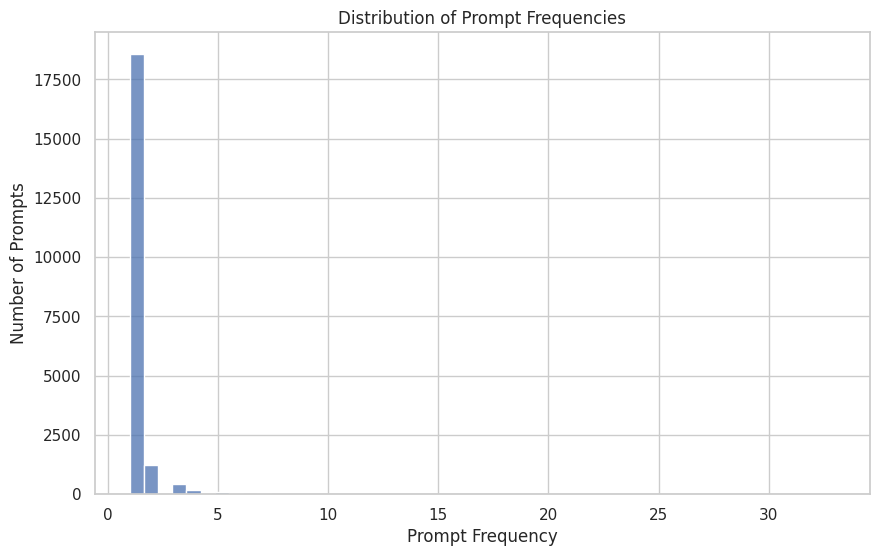

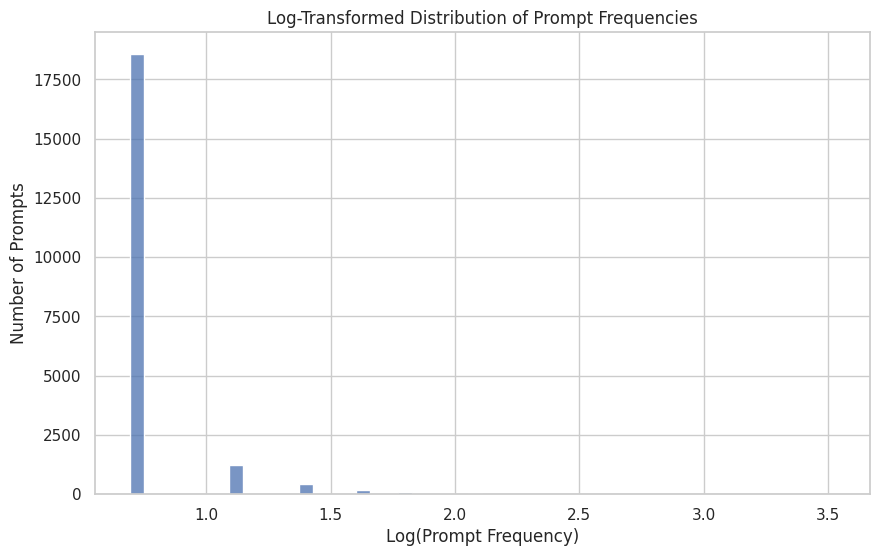

Top 10 Most Repeated Prompts with Counts:
prompt
What is the meaning of life?                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
#look at the distribution of repeated prompts.
#apparently there's about 1200 prompts that are repeated twice, and a couple dozen repeated 4 or 5 times
#so not something to investigate further (it's not like there's 1 or 2 prompts repeated hundreds of times, which could be interesting to see how models responded)

plt.figure(figsize=(10, 6))
sns.histplot(unique_counted, bins=50)
plt.title("Distribution of Prompt Frequencies")
plt.xlabel("Prompt Frequency")
plt.ylabel("Number of Prompts")
plt.show()

# Log-transformed histogram to deal with skewed data
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(unique_counted), bins=50)  # log1p to handle log(0) issues
plt.title("Log-Transformed Distribution of Prompt Frequencies")
plt.xlabel("Log(Prompt Frequency)")
plt.ylabel("Number of Prompts")
plt.show()

# Display top 10 repeated prompts
print("Top 10 Most Repeated Prompts with Counts:")
print(unique_counted.head(10))

#### Visualizing length of the responses

Text(0, 0.5, 'Count')

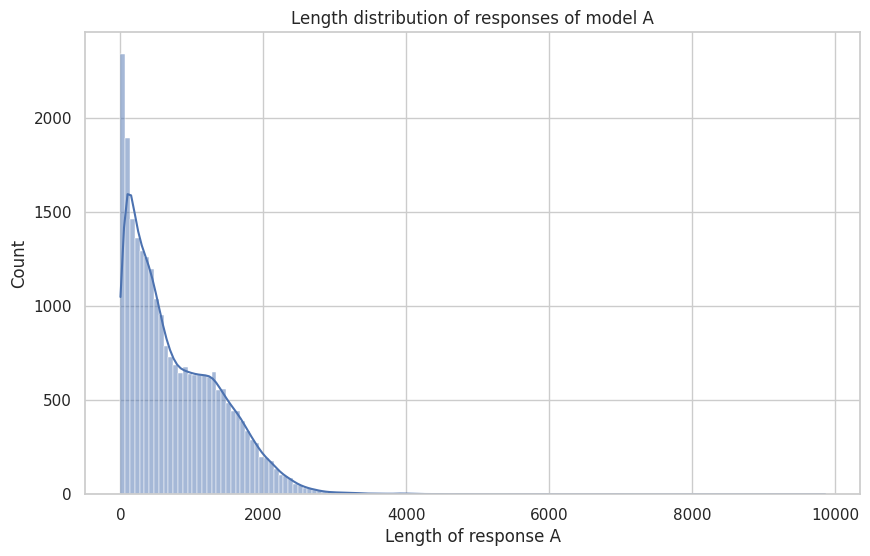

In [ ]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["response_a_length"], kde=True)
plt.title("Length distribution of responses of model A")
plt.xlabel("Length of response A")
plt.ylabel("Count")

Text(0, 0.5, 'Frequency')

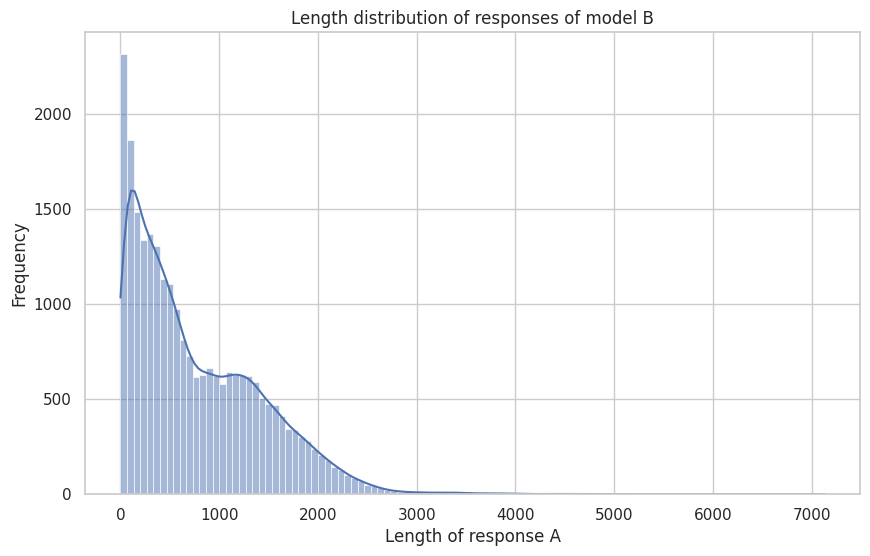

In [ ]:
# Plot the distribution of the length of the responses
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["response_b_length"], kde=True)
plt.title("Length distribution of responses of model B")
plt.xlabel("Length of response A")
plt.ylabel("Frequency")

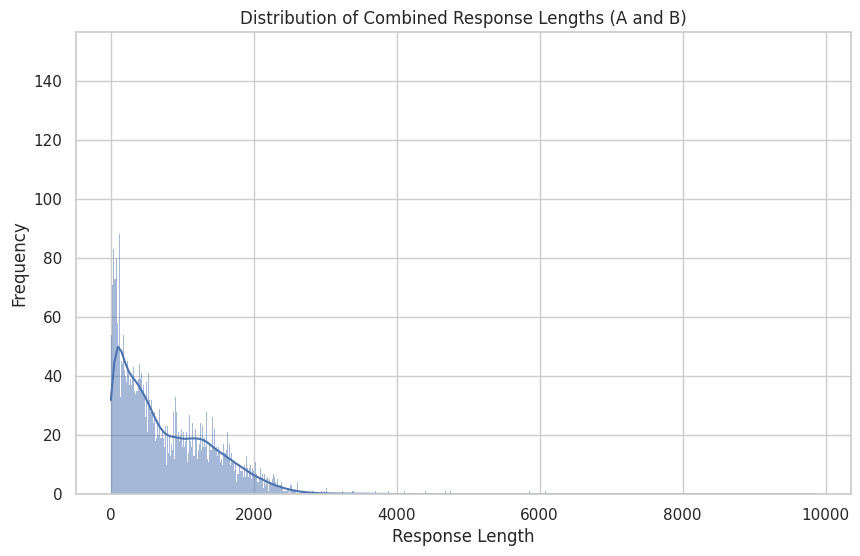

In [ ]:
# Concatenate response lengths into a single Series
combined_response_lengths = pd.concat([filtered_df['response_a_length'], filtered_df['response_b_length']], ignore_index=True)

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(combined_response_lengths, binwidth=1, kde=True)
plt.title("Distribution of Combined Response Lengths (A and B)")
plt.xlabel("Response Length")
plt.ylabel("Frequency")
plt.show()


#### Visualizing the correlation in length of the responses for both models a and b

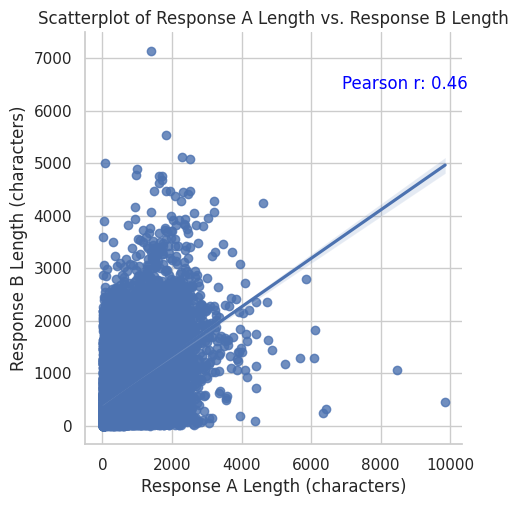

In [ ]:
#Scatterplot of responses a and b length, to see a correlation. Also plot pearson correlation coefficient on it
from scipy.stats import pearsonr
correlation, _ = pearsonr(filtered_df['response_a_length'], filtered_df['response_b_length'])

sns.lmplot(data=filtered_df, x="response_a_length", y="response_b_length", fit_reg=True) #the correlation seems to be quite weak, which is interesting to write about in the EDA - the models do not necessarily respond with the same length to the same questions
plt.title("Scatterplot of Response A Length vs. Response B Length")

plt.text(
    x=filtered_df['response_a_length'].max() * 0.7,  # Positioning the text
    y=filtered_df['response_b_length'].max() * 0.9,
    s=f"Pearson r: {correlation:.2f}",
    fontsize=12,
    color="blue"
)

plt.xlabel("Response A Length (characters)")
plt.ylabel("Response B Length (characters)")
plt.show()


#### Visualizing the average response lengths per model

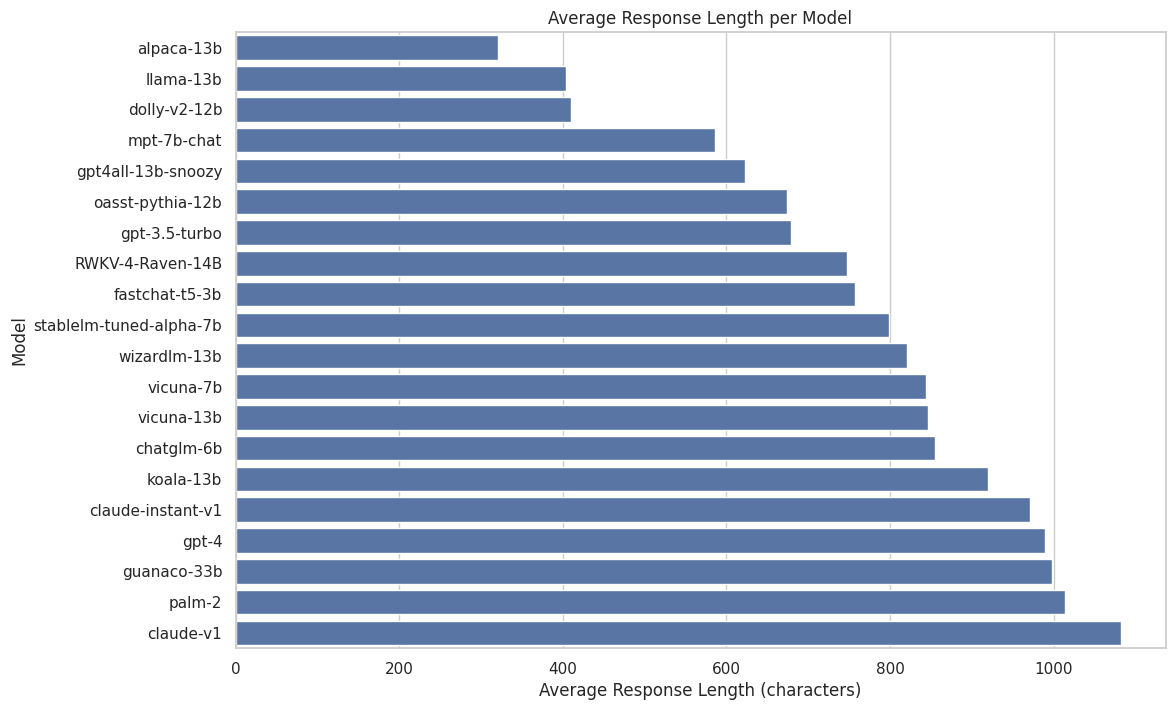

In [ ]:
#This plot to compare average response lengths between models I do think is relevant! esp if we can compare it to winning rate / calculate that. I think winning rate should be a feature
# Stack the response lengths and models into one DataFrame
stacked_df = pd.concat([
    filtered_df[['model_a', 'response_a_length']].rename(columns={'model_a': 'model', 'response_a_length': 'response_length'}),
    filtered_df[['model_b', 'response_b_length']].rename(columns={'model_b': 'model', 'response_b_length': 'response_length'})
])

# Calculate average response length per model
model_avg_response_length = stacked_df.groupby('model')['response_length'].mean().sort_values()

# Plot the average response length per model
plt.figure(figsize=(12, 8))
sns.barplot(x=model_avg_response_length.values, y=model_avg_response_length.index)
plt.title("Average Response Length per Model")
plt.xlabel("Average Response Length (characters)")
plt.ylabel("Model")
plt.show()

#### Testing the correlation between prompt length and response length

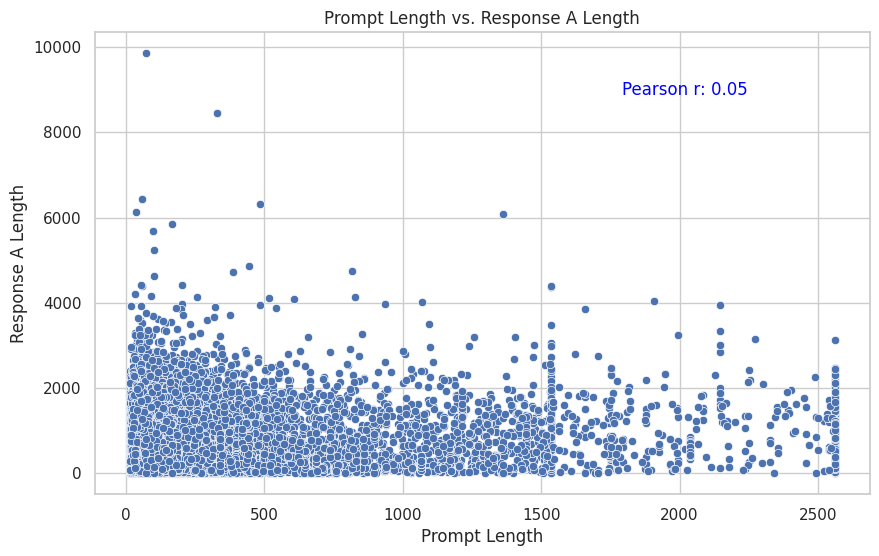

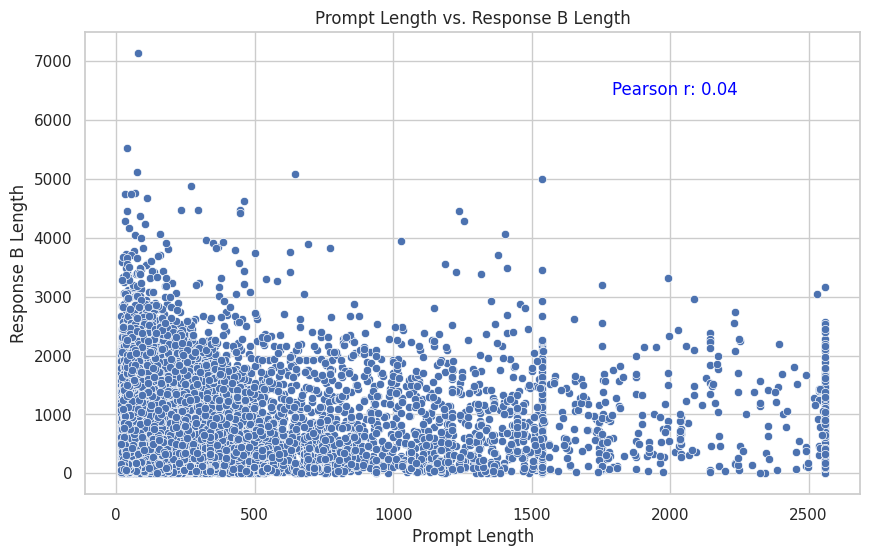

In [ ]:
#See if prompt length and response length are correlated. Answer: no.
#I don't think these correlations are the most relevant for our EDA analysis, we should mostly be looking at correlations with the winning rate

#correlation for prompt length vs. response_a_length
correlation_a, _ = pearsonr(filtered_df["prompt_length"], filtered_df["response_a_length"])

# Scatter plot for prompt & response a
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x="prompt_length", y="response_a_length")
plt.title("Prompt Length vs. Response A Length")
plt.xlabel("Prompt Length")
plt.ylabel("Response A Length")
plt.text(
    x=filtered_df["prompt_length"].max() * 0.7,
    y=filtered_df["response_a_length"].max() * 0.9,
    s=f"Pearson r: {correlation_a:.2f}",
    fontsize=12,
    color="blue"
)
plt.show()

# Calculate correlation for prompt length vs. response_b_length
correlation_b, _ = pearsonr(filtered_df["prompt_length"], filtered_df["response_b_length"])

# Scatter plot for prompt length vs. response_b_length
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x="prompt_length", y="response_b_length")
plt.title("Prompt Length vs. Response B Length")
plt.xlabel("Prompt Length")
plt.ylabel("Response B Length")
plt.text(
    x=filtered_df["prompt_length"].max() * 0.7,  # Adjust x position
    y=filtered_df["response_b_length"].max() * 0.9,  # Adjust y position
    s=f"Pearson r: {correlation_b:.2f}",
    fontsize=12,
    color="blue"
)
plt.show()

In [ ]:
#see how many unique models we have as a simple description statistic
len(df['model_a'].value_counts())
#to be sure to count for both models:
# Get unique models in model_a and model_b
unique_models_a = set(df['model_a'].unique())
unique_models_b = set(df['model_b'].unique())
all_unique_models = unique_models_a.union(unique_models_b)
num_unique_models = len(all_unique_models)
print(f"Total unique models: {num_unique_models}")

Total unique models: 20


## Hardness score distribution and its correlation with the models (E)

#### Analyzing the Variance in Hardness Scores

<ipython-input-43-5700a0847c80>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='winner_name', y='hardness_score', data=filtered_df_no_tie[filtered_df_no_tie['winner_name'] == winner], palette='viridis')
<ipython-input-43-5700a0847c80>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='winner_name', y='hardness_score', data=filtered_df_no_tie[filtered_df_no_tie['winner_name'] == winner], palette='viridis')
<ipython-input-43-5700a0847c80>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='winner_name', y='hardness_score', data=filtere

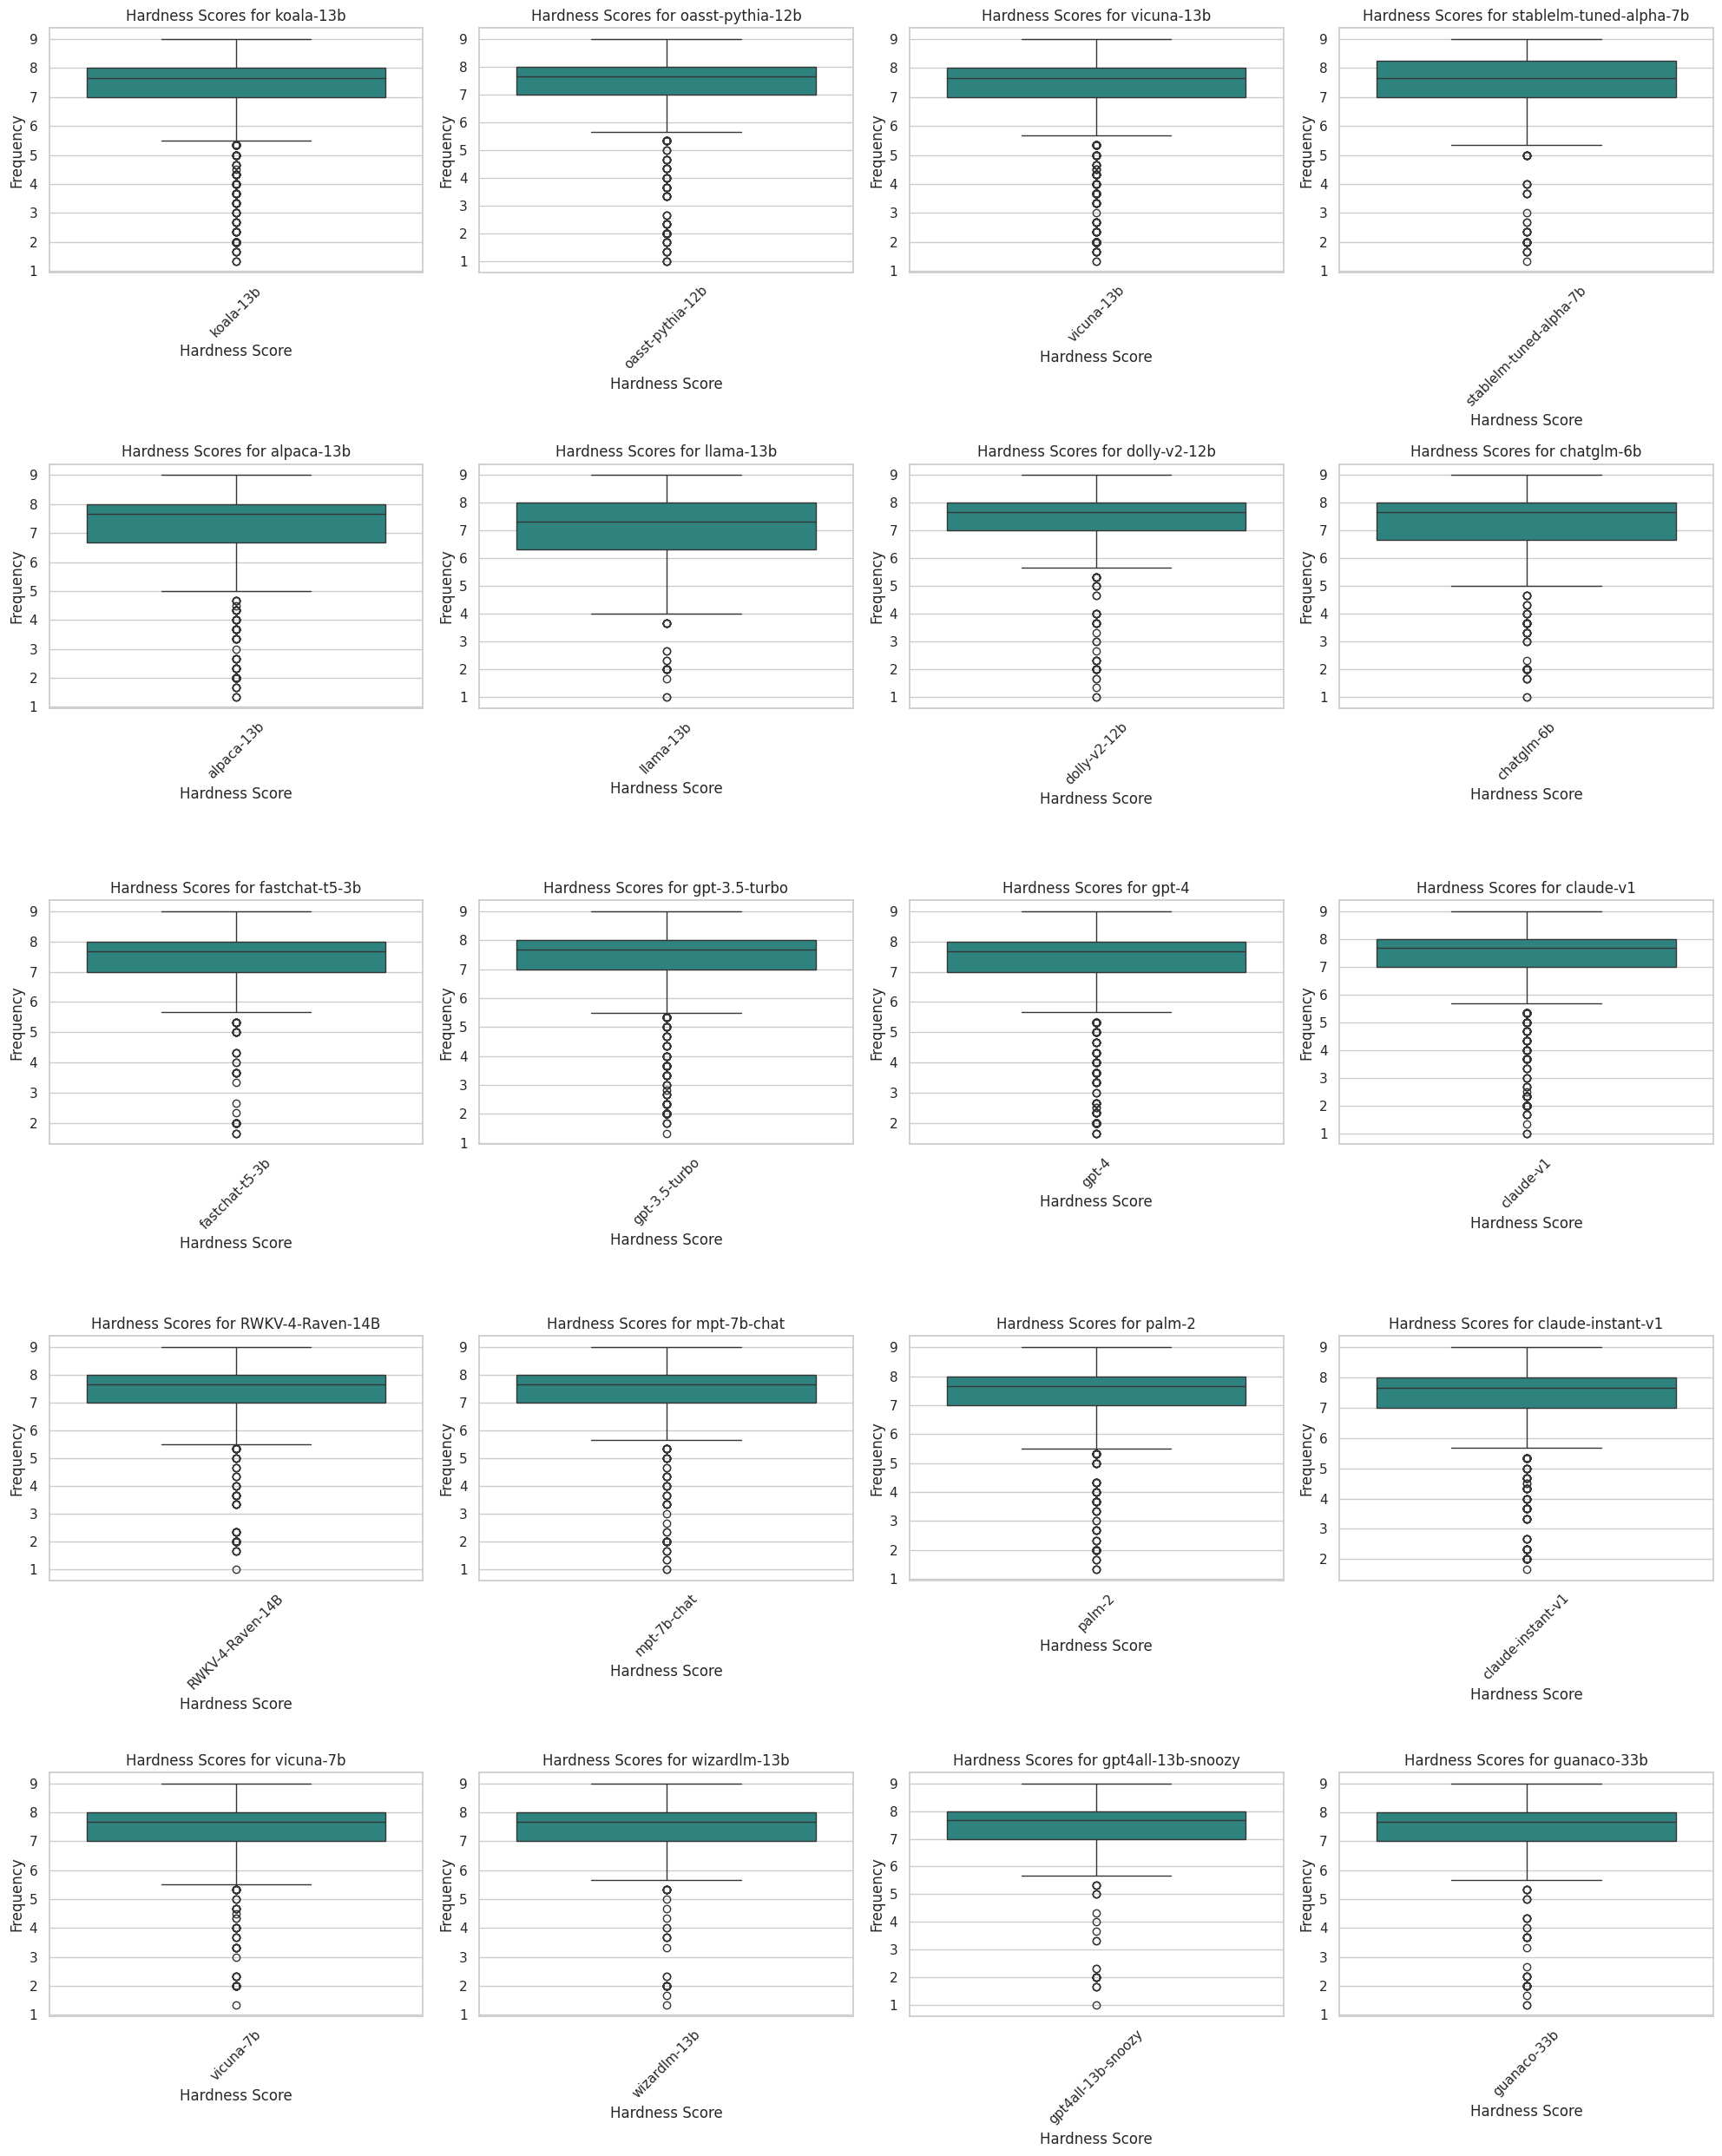

In [ ]:
#create boxplots for each of the chatbots showing the range of hardness for the prompts they won
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df_no_tie = filtered_df[~filtered_df['winner_name'].str.contains('&', na=False)]

unique_winners = filtered_df_no_tie['winner_name'].unique()

# Set up the figure size and subplots
num_winners = len(unique_winners)
cols = 4  # Number of columns for the subplots
rows = (num_winners + cols - 1) // cols  # Calculate the required number of rows

plt.figure(figsize=(20, 5 * rows))

# Create a box plot for each unique winner name
for i, winner in enumerate(unique_winners):
    plt.subplot(rows, cols, i + 1)  # Create a subplot for each winner
    sns.boxplot(x='winner_name', y='hardness_score', data=filtered_df_no_tie[filtered_df_no_tie['winner_name'] == winner], palette='viridis')
    plt.title(f'Hardness Scores for {winner}')
    plt.xlabel('Hardness Score')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

 #### Vizualizing the distribution of hardness scores in the dataset.

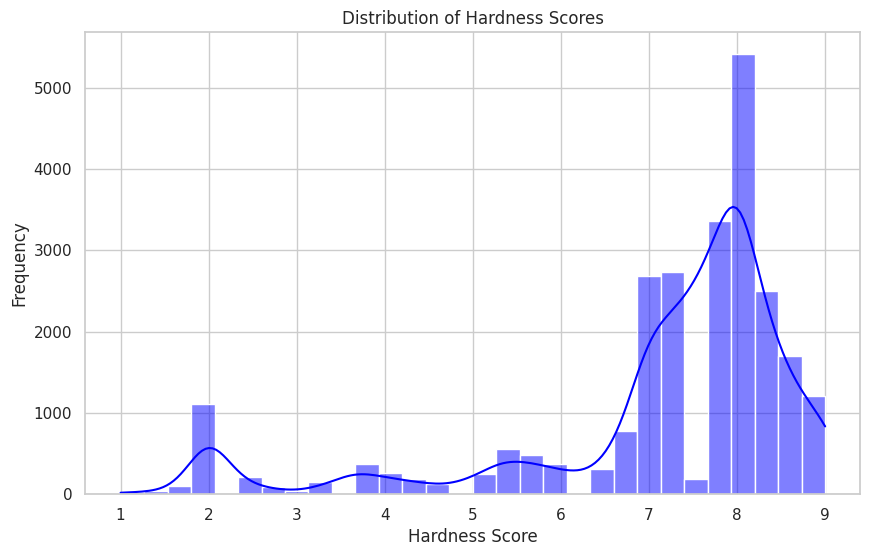

In [ ]:
# plot the hardness score distribution
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df["hardness_score"], bins=30, kde=True, color="blue")
plt.title("Distribution of Hardness Scores")
plt.xlabel("Hardness Score")
plt.ylabel("Frequency")
plt.show()

#### average hardness for all 20 models and their corresponding correlations


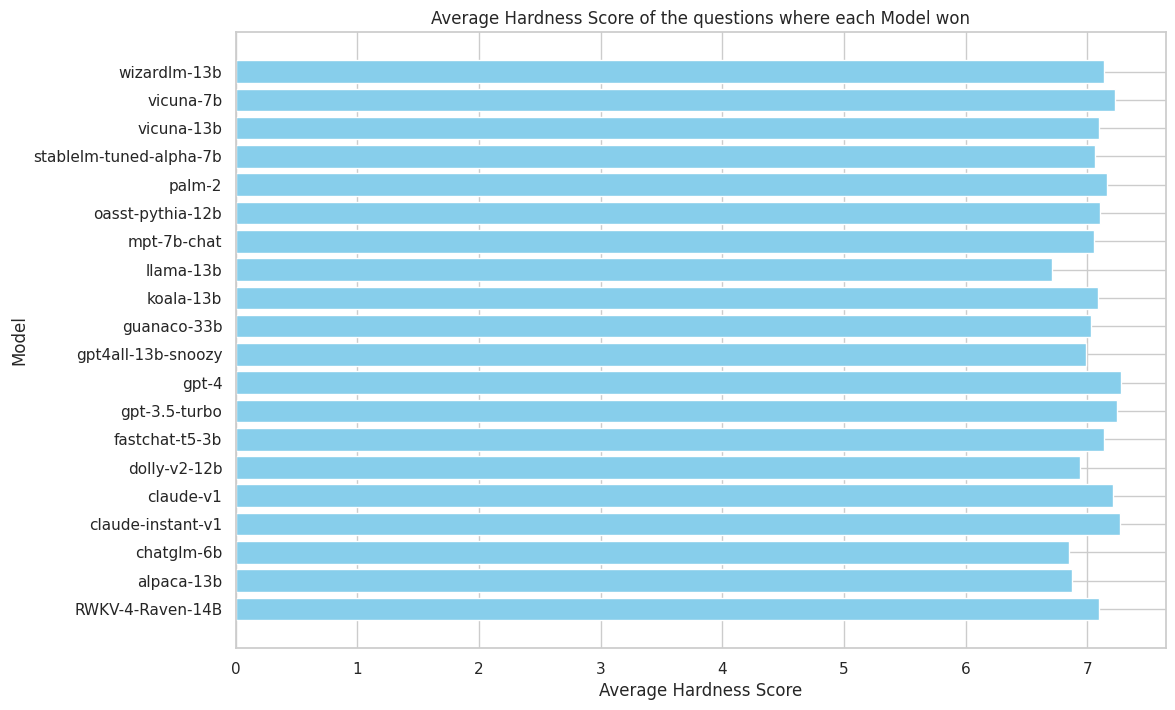

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between Average Hardness Score and Win Rate: nan


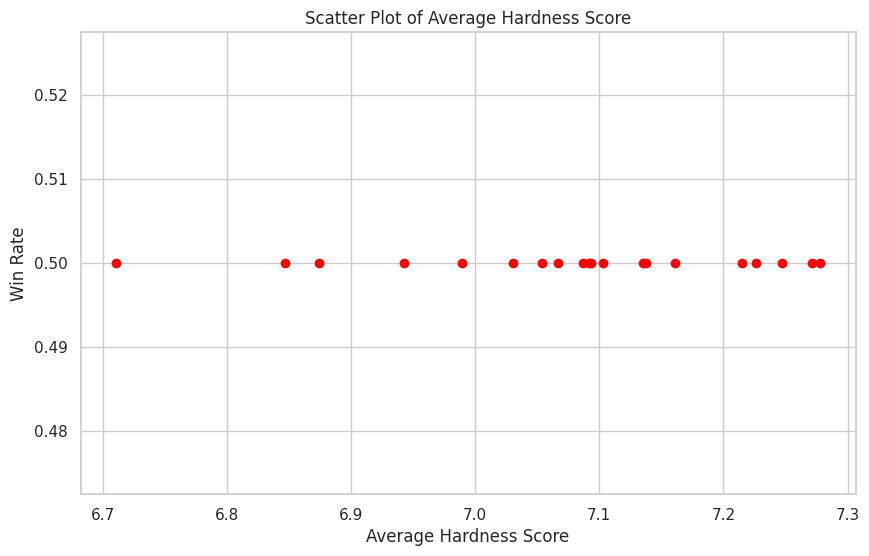

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of 20 target models
target_models = [
    'gpt-4', 'claude-v1', 'claude-instant-v1', 'gpt-3.5-turbo', 'vicuna-13b',
    'palm-2', 'guanaco-33b', 'wizardlm-13b', 'koala-13b', 'vicuna-7b',
    'mpt-7b-chat', 'gpt4all-13b-snoozy', 'oasst-pythia-12b', 'RWKV-4-Raven-14B',
    'alpaca-13b', 'chatglm-6b', 'fastchat-t5-3b', 'stablelm-tuned-alpha-7b',
    'dolly-v2-12b', 'llama-13b'
]

# Step 1: Filter for the target models
filtered_models_df = filtered_df[filtered_df['winner_name'].isin(target_models)]

# Step 2: Calculate the average hardness score per model
model_hardness_summary = (
    filtered_models_df.groupby('winner_name')['hardness_score']
    .mean()
    .reset_index()
    .rename(columns={'hardness_score': 'average_hardness_score'})
)

# Step 3: Calculate the win rate for each model
# Separate wins for model_a and model_b
model_a_wins = filtered_models_df[['winner_name', 'one_hot_a']].rename(columns={'one_hot_a': 'win'})
model_b_wins = filtered_models_df[['winner_name', 'one_hot_b']].rename(columns={'one_hot_b': 'win'})
combined_wins = pd.concat([model_a_wins, model_b_wins])

# Calculate win rate
win_rate_summary = combined_wins.groupby('winner_name')['win'].mean().reset_index()

# Step 4: Merge win rate and average hardness score
model_summary = pd.merge(model_hardness_summary, win_rate_summary, on='winner_name')

# Step 5: Plot average hardness score with win rate as annotations
plt.figure(figsize=(12, 8))
bars = plt.barh(model_summary['winner_name'], model_summary['average_hardness_score'], color='skyblue')
plt.xlabel("Average Hardness Score")
plt.ylabel("Model")
plt.title("Average Hardness Score of the questions where each Model won")
plt.show()

# Step 6: Calculate and display the correlation between average hardness score and win rate
correlation = model_summary['average_hardness_score'].corr(model_summary['win'])
print("Correlation between Average Hardness Score and Win Rate:", correlation)

# Step 7: Scatter plot to visualize the relationship between hardness score and win rate
plt.figure(figsize=(10, 6))
plt.scatter(model_summary['average_hardness_score'], model_summary['win'], color='red')
plt.xlabel("Average Hardness Score")
plt.ylabel("Win Rate")
plt.title("Scatter Plot of Average Hardness Score")
plt.show()

In [ ]:
# Define bins and labels for hardness scores
bins = [0, 4, 7, 10]  # 0–4: Low, 4–7: Medium, 7–10: High
labels = ['Low', 'Medium', 'High']
filtered_df['hardness_category'] = pd.cut(filtered_df['hardness_score'], bins=bins, labels=labels)
# Group by hardness category and winner to count occurrences
outcome_by_hardness = filtered_df.groupby(['hardness_category', 'winner_name']).size().unstack().fillna(0)
print("Outcome Frequency by Hardness Category:")
print(outcome_by_hardness)

Outcome Frequency by Hardness Category:
winner_name        RWKV-4-Raven-14B  RWKV-4-Raven-14B & alpaca-13b  \
hardness_category                                                    
Low                              64                              4   
Medium                          145                              8   
High                            443                             20   

winner_name        RWKV-4-Raven-14B & chatglm-6b  \
hardness_category                                  
Low                                            2   
Medium                                         7   
High                                          17   

winner_name        RWKV-4-Raven-14B & claude-instant-v1  \
hardness_category                                         
Low                                                   2   
Medium                                                3   
High                                                  9   

winner_name        RWKV-4-Raven-14B & claude-v1  \
h

<ipython-input-46-5d2fb731bee2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['hardness_category'] = pd.cut(filtered_df['hardness_score'], bins=bins, labels=labels)
<ipython-input-46-5d2fb731bee2>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outcome_by_hardness = filtered_df.groupby(['hardness_category', 'winner_name']).size().unstack().fillna(0)


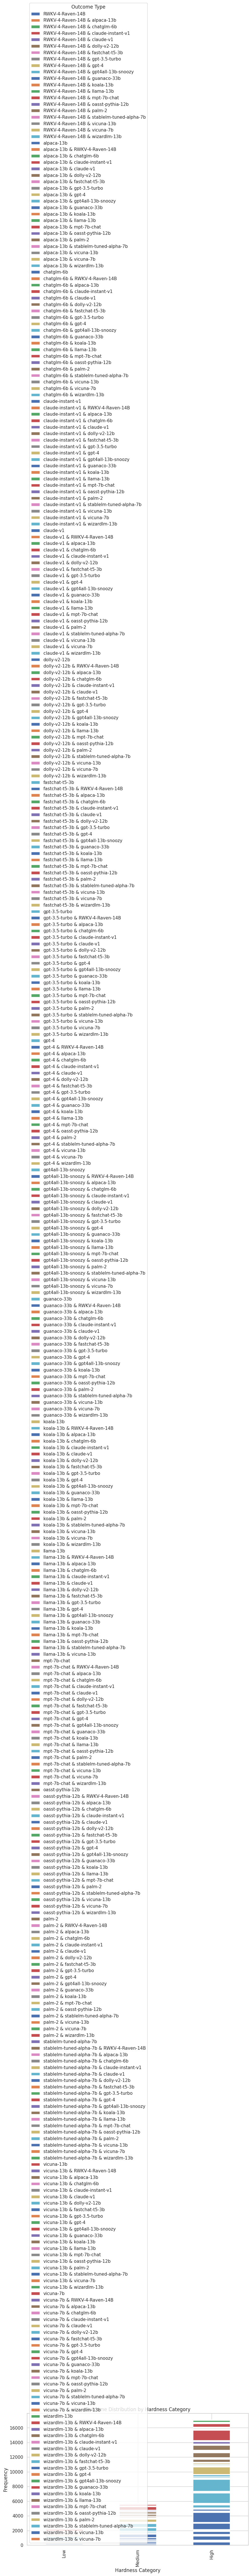

In [ ]:
# Plot outcome distribution by hardness category
outcome_by_hardness.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Outcome Distribution by Hardness Category")
plt.xlabel("Hardness Category")
plt.ylabel("Frequency")
plt.legend(title="Outcome Type")
plt.show()


## Analyzing the topic distribution
How is the models' relative performance affected by the topics of the prompts, determined by the topic modeling results of the ChatGPT3.5 model on the prompts. In our Data Cleaning we decided to use topic_modeling_3.

First: assess the frequency of topics.

Text(0, 0.5, 'Amount of topics with that frequency')

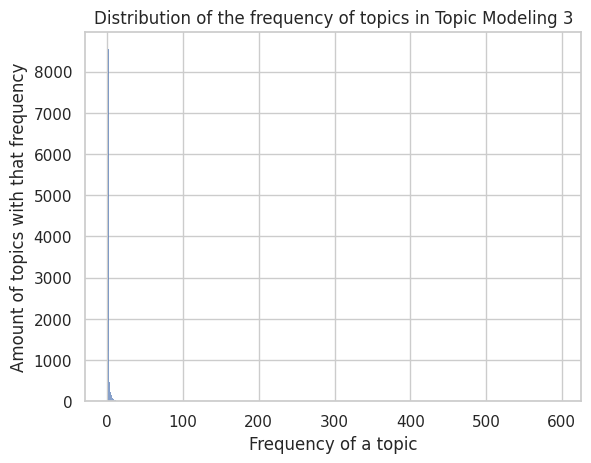

In [ ]:
#Count topics
topic3_counts=merged_df["topic_modeling_3"].value_counts()
topic3_counts
sns.histplot(topic3_counts, binwidth=1)
plt.title("Distribution of the frequency of topics in Topic Modeling 3")
plt.xlabel("Frequency of a topic")
plt.ylabel("Amount of topics with that frequency")
#Result: the topics seem to be mostly unique, that's going to make it hard.
#topic1_counts_repeats=topic1_counts[topic1_counts>7] #in this line, uncommentable I made plots to closer examine the distribution - eg see if we had just a very high peak of 1's, but there's also high peaks up until about 15
#sns.histplot(topic1_counts_repeats, binwidth=1)

In [ ]:
#Assess number of unique topics
len(topic3_counts)

11174

In [ ]:
#get the most frequently occurring topics
topic3_counts[0:30]

topic_modeling_3
Creative Writing                     596
Factual Accuracy                     487
Problem-solving, Creativity          407
Factual Knowledge                    314
Problem Solving                      290
Math Problem                         206
Information Retrieval                197
Problem-solving, Factual accuracy    174
Problem-Solving, Creativity          158
Creativity, Humor                    145
Decision Making                      113
Logic Puzzle                         105
Problem-Solving                      102
Creativity, Factual Accuracy          89
Creativity, Problem-solving           87
Mathematical Calculation              81
Philosophical Inquiry                 80
Comparison Analysis                   74
Factual Recall                        74
Problem-Solving, Factual Accuracy     74
Geography Knowledge                   72
Language Translation                  72
Creative Thinking                     72
Travel Planning                       72
Data Analysis                         66
Storytelling, Creativity              64
Mathematics, Logic                    55
List Generation                       54
Ethical Dilemma                       52
Mathematics, Arithmetic               51
Name: count, dtype: int64

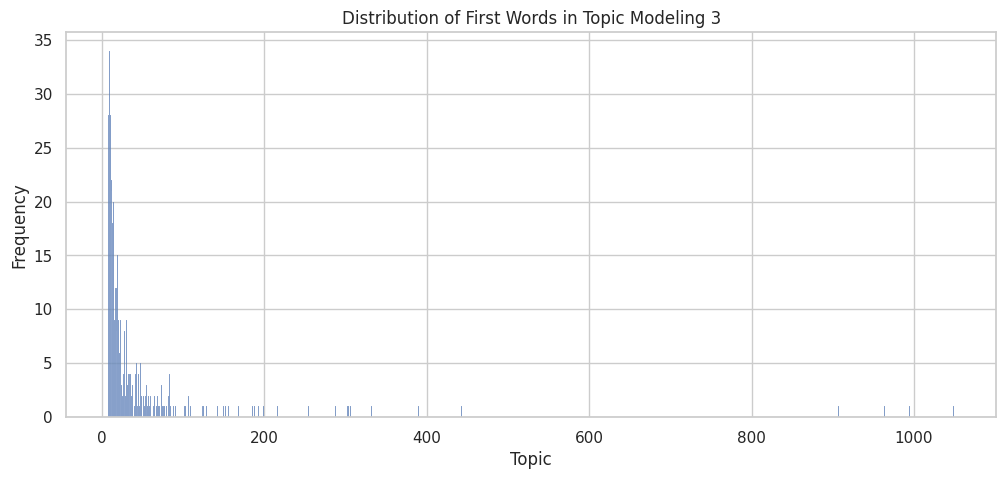

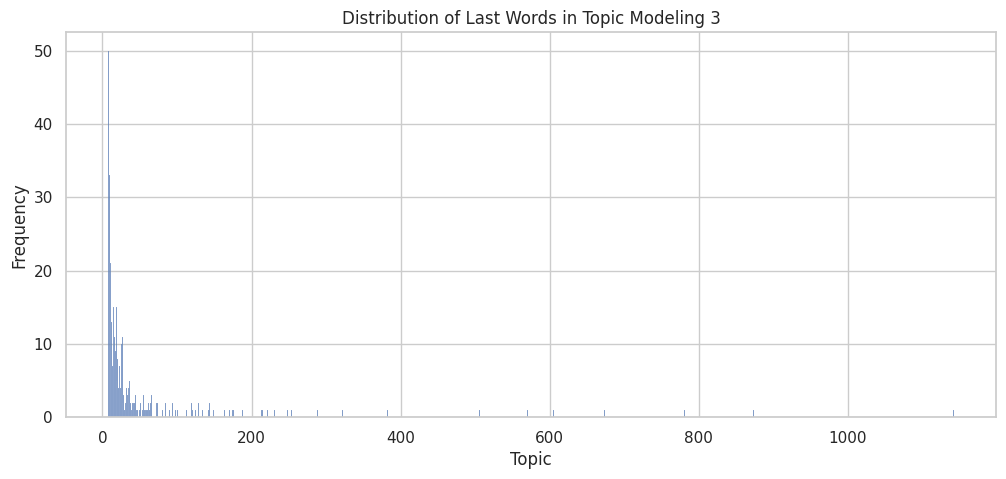

In [ ]:
#Seeing if it's different if I split the topics into words, I first looked at them split into first & last words, because they might be different characters
#eg the last word being more descriptive like 'analsis', and the first being the actual topic
#but this didn't really give useful information
topic3_split=merged_df["topic_modeling_3"].str.split(" ")
topic3_split

# Extracting the first and last words from the split lists
merged_df['topic3_first_word'] = topic3_split.str[0]
merged_df['topic3_last_word'] = topic3_split.str[-1]

# Getting value counts for first and last words
first_word_counts = merged_df['topic3_first_word'].value_counts()
last_word_counts = merged_df['topic3_last_word'].value_counts()

# Filtering counts for better visualization (e.g., count > 7)
first_word_counts_repeats = first_word_counts[first_word_counts > 7]
last_word_counts_repeats = last_word_counts[last_word_counts > 7]

# Plotting distributions
plt.figure(figsize=(12, 5))
sns.histplot(first_word_counts_repeats, binwidth=1)
plt.title("Distribution of First Words in Topic Modeling 3")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(last_word_counts_repeats, binwidth=1)
plt.title("Distribution of Last Words in Topic Modeling 3")
plt.xlabel("Topic")
plt.ylabel("Frequency")
plt.show()


In [ ]:
first_word_counts

topic3_first_word
Factual             1049
Creativity,          994
Problem-solving,     963
Creative             906
Mathematics,         534
                    ... 
Accounting,            1
Games,                 1
Dosage                 1
Spamming               1
Civil                  1
Name: count, Length: 2624, dtype: int64

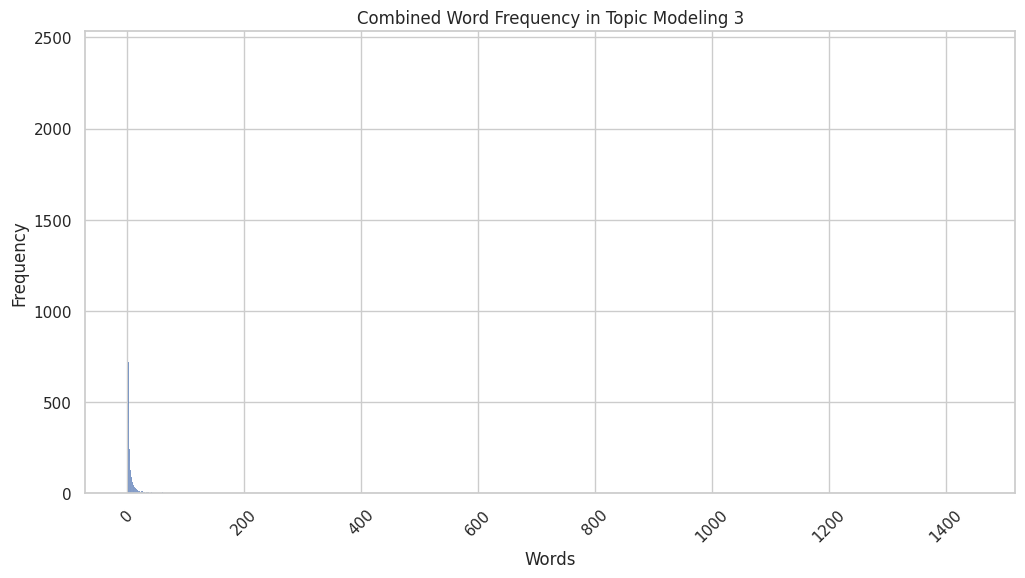

In [ ]:
# Now let's look at all of the split words and see if we have more words that occur more frequently
# Split and combine all words in topic_modeling_1 into a single series
all_words = merged_df['topic_modeling_3'].str.split(expand=True).stack()

#Get the frequency of each word
word_counts = all_words.value_counts()

# Plotting the distribution of all words. The answer is: no this doesn't make a difference.
plt.figure(figsize=(12, 6))
sns.histplot(word_counts, binwidth=1)
plt.title("Combined Word Frequency in Topic Modeling 3")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [ ]:
word_counts.head()

Factual             1446
Analysis            1143
Creativity,          997
Problem-solving,     963
Creative             918
Name: count, dtype: int64

In [ ]:
# The list of topics that are repeated the most does give us some information.
# Looking at it, we can manually discern four areas; math, fact (factual analysis), creativity/creative writing, and problem-solving/problems
# This code analyzes those four categories.
# Define core words of interest
core_words = [
    r'math',                       # Matches "math"
    r'fact\w*',                    # Matches "fact", "facts", "factual", etc.
    r'creativ\w*',                 # Matches "creative", "creativity", etc.
    r'problem[ -]?solving'         # Matches "problem-solving" and "problem solving"
]





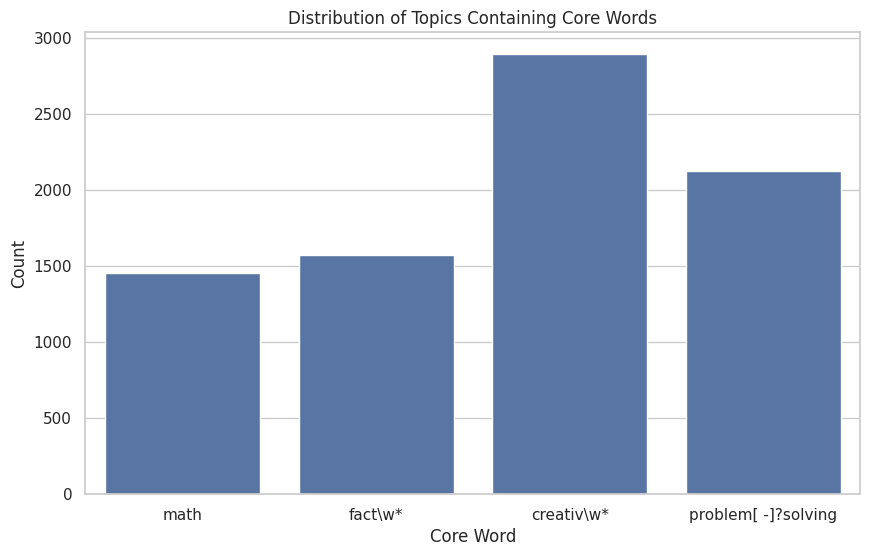

In [ ]:
# Calculate topic distribution using regex
import regex as re
topic_distribution = {
    core_word: (
        merged_df['topic_modeling_3'].str.contains(core_word, flags=re.IGNORECASE, na=False, regex=True).sum()
    )
    for core_word in core_words
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(topic_distribution.keys()), y=list(topic_distribution.values()))
plt.title("Distribution of Topics Containing Core Words")
plt.xlabel("Core Word")
plt.ylabel("Count")
plt.show()

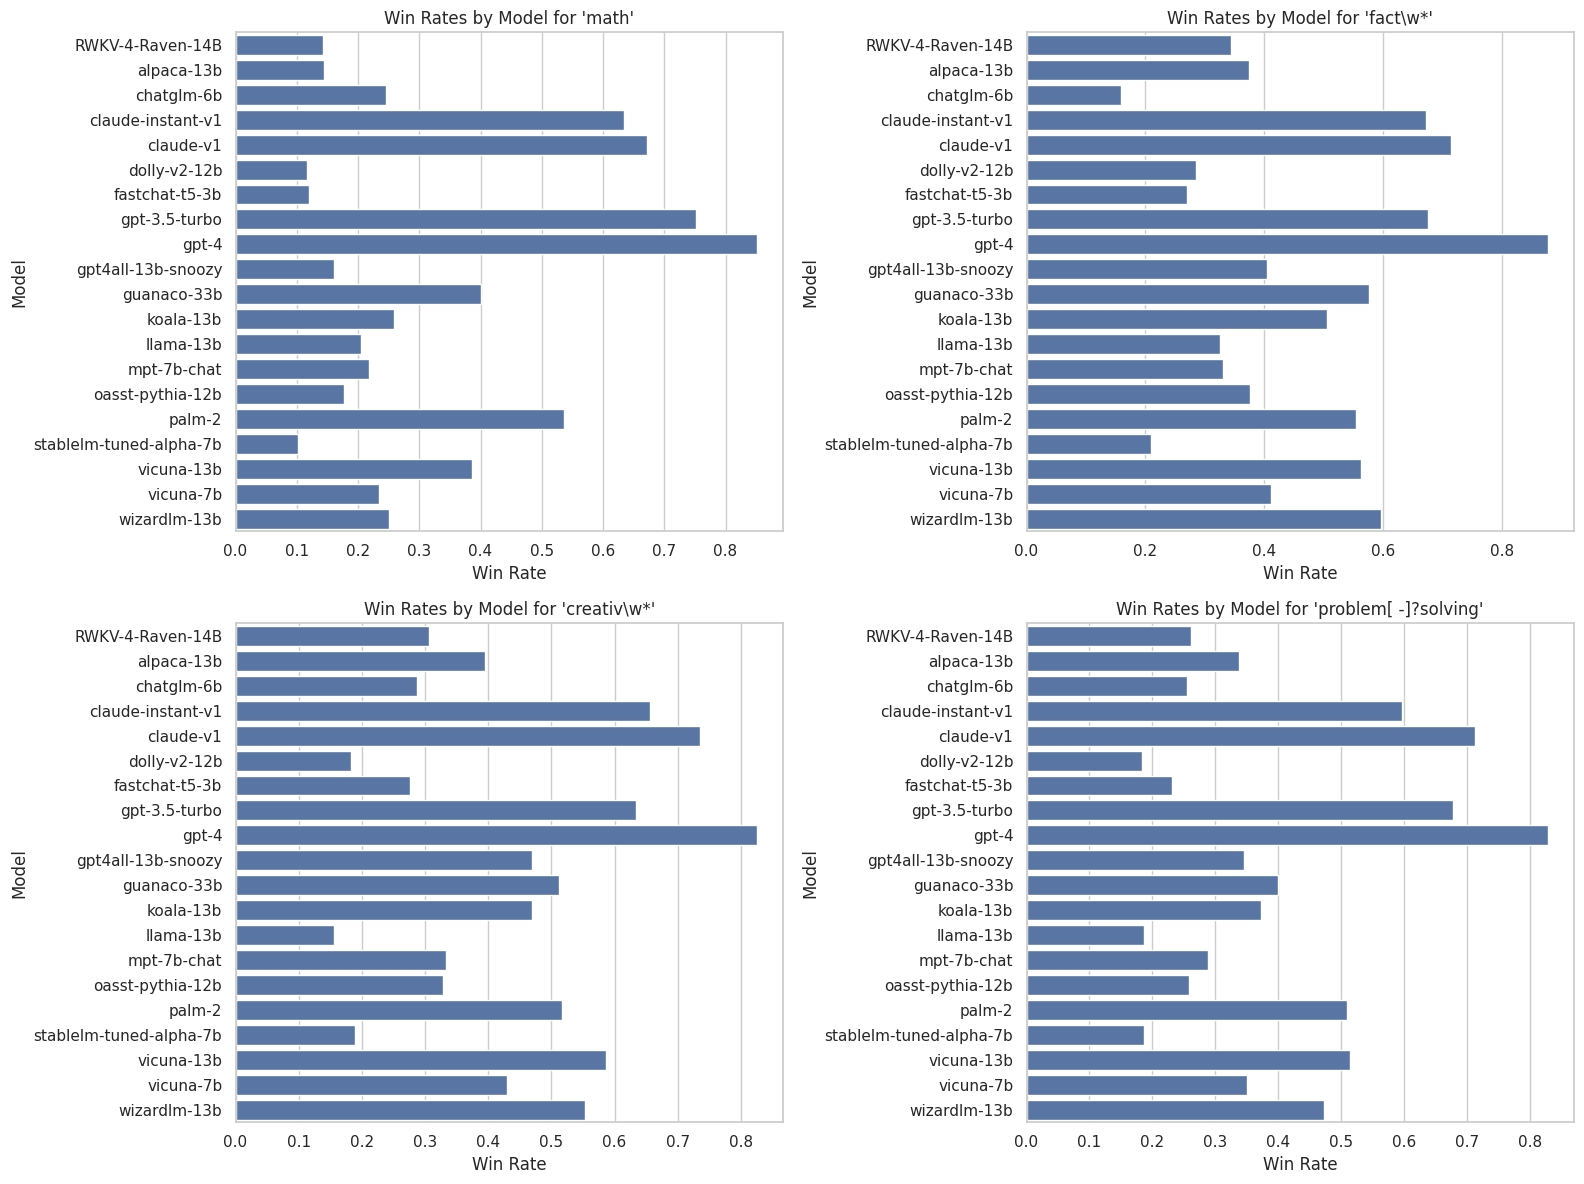

In [ ]:


# Calculate win rates for each core word and store them in a list
win_rate_data = []
for core_word in core_words:
    # Filter rows where any topic column contains the core word
    topic_df = filtered_df[

        filtered_df['topic_modeling_3'].str.contains(core_word, case=False, na=False)
    ]

    # Separate data for model_a and model_b with their respective win indicators
    model_a_wins = topic_df[['model_a', 'one_hot_a']].rename(columns={'model_a': 'model', 'one_hot_a': 'win'})
    model_b_wins = topic_df[['model_b', 'one_hot_b']].rename(columns={'model_b': 'model', 'one_hot_b': 'win'})

    # Combine both model_a and model_b win data for this topic
    combined_model_wins = pd.concat([model_a_wins, model_b_wins])

    # Calculate win rate for each model for this specific core word
    win_rates = combined_model_wins.groupby('model')['win'].mean().reset_index()
    win_rates['topic'] = core_word  # Add core word as a new column
    win_rate_data.append(win_rates)

# Concatenate all win rate data into a single DataFrame
win_rate_df = pd.concat(win_rate_data)

# Sort models alphabetically for consistent ordering across plots
win_rate_df['model'] = win_rate_df['model'].astype(str)
win_rate_df = win_rate_df.sort_values(by='model')

# Plot separate bar charts for each core word
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, core_word in enumerate(core_words):
    sns.barplot(
        data=win_rate_df[win_rate_df['topic'] == core_word],
        x='win',
        y='model',
        ax=axes[idx]
    )
    axes[idx].set_title(f"Win Rates by Model for '{core_word}'")
    axes[idx].set_xlabel("Win Rate")
    axes[idx].set_ylabel("Model")
    axes[idx].tick_params(axis='y', rotation=0)  # Keep model names horizontal

plt.tight_layout()
plt.show()

## Punctuation Feature

#### Creating a feature for punctuation within the prompts

In [ ]:
# punctuation marks to encode
punctuation_marks = [".", ",", "!", "?"]

def enc_punctuation(text):
  """checks the presence of punctuation marks in the prompt."""
  encode = {}
  for mark in punctuation_marks:
      encode[f"has_{mark}"] = int(mark in text)
  return encode

# apply function to the prompt column
df_punct = filtered_df["prompt"].apply(lambda x: enc_punctuation(x if x else ''))
punct_df = pd.DataFrame(list(df_punct))

# merge feature columns
punctuation_df = pd.concat([filtered_df, punct_df], axis=1)

punctuation_df.head()

question_id           model_a           model_b  \
0  58210e39b3fd4441a2bd4a518bb44c2d        chatglm-6b         koala-13b   
1  2564acd09e3942fd97657d05282d4389  oasst-pythia-12b        alpaca-13b   
2  90bfd142157948aba01931726c888e7f         koala-13b  oasst-pythia-12b   
3  a7c5accc53e649a3bc6b2e41d962ebc4        vicuna-13b  oasst-pythia-12b   
4  adf27e819a3c494cb6e993f0c660e097        vicuna-13b         koala-13b   

    winner           judge                                     conversation_a  \
0  model_b  arena_user_973  [{'content': 'What is the difference between O...   
1      tie  arena_user_973  [{'content': 'Why did my parent not invite me ...   
2  model_b  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  model_b  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  model_a  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
1  [{'content': 'Why did my parent not invite me ...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   

                                              prompt  prompt_length  \
0    What is the difference between OpenCL and CUDA?           47.0   
1  Why did my parent not invite me to their wedding?           49.0   
2                   Fuji vs. Nikon, which is better?           32.0   
3                How to build an arena for chatbots?           35.0   
4                                  When is it today?           17.0   

                     winner_name  ...  winner_name_id  hardness_score  \
0                      koala-13b  ...             [0]        8.666667   
1  oasst-pythia-12b & alpaca-13b  ...         [14, 2]        8.333333   
2               oasst-pythia-12b  ...            [14]        3.333333   
3               oasst-pythia-12b  ...            [14]        8.000000   
4                     vicuna-13b  ...            [12]        2.000000   

         topic_modeling_3 win_model_a  win_model_b  hardness_category has_.  \
0  Comparison, Technology         0.0          1.0               High   0.0   
1    Reasoning, Emotional         1.0          1.0               High   0.0   
2  Photography comparison         0.0          1.0                Low   1.0   
3           Chatbot Arena         0.0          1.0               High   0.0   
4      Time-based Inquiry         1.0          0.0                Low   0.0   

   has_, has_!  has_?  
0    0.0   0.0    1.0  
1    0.0   0.0    1.0  
2    1.0   0.0    1.0  
3    0.0   0.0    1.0  
4    0.0   0.0    1.0  

[5 rows x 26 columns]

## Sentiment Scores

In [ ]:
import torch
import transformers
from transformers import pipeline
model_checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
sentiment_analysis = pipeline("sentiment-analysis", model=model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
topic_and_hardness['prompt'] = topic_and_hardness['prompt'].astype(str)

In [ ]:
truncated1_df = pd.DataFrame({
    'question_id': topic_and_hardness.index,
    'truncated_prompt': [prompt[:100] for prompt in topic_and_hardness['prompt']]
})

print(truncated_df.head())

NameError: name 'truncated_df' is not defined

In [ ]:
#truncated_prompts = [prompt for prompt in truncated_df['truncated_prompt']]
#sentiment_results = sentiment_analysis(truncated_prompts)


# Initialize columns
#if 'sentiment_score' not in truncated_df.columns:
    #truncated_df['sentiment_score'] = pd.NA

#if 'sentiment_confidence' not in truncated_df.columns:
    #truncated_df['sentiment_confidence'] = pd.NA

#for j, result in enumerate(sentiment_results):
    #idx = j
    #truncated_df.loc[idx, 'sentiment_score'] = result['label']
    #truncated_df.loc[idx, 'sentiment_confidence'] = result['score']


In [ ]:
#import sentiment data
sentiment = pd.read_json(
    "truncated_data2.json",
    lines=True

In [ ]:
#convert scores to numeric
sentiment['sentiment_confidence'] = pd.to_numeric(sentiment['sentiment_confidence'], errors='coerce')

In [ ]:
#merge sentiment data into df
sentiment_merged = merged_df.merge(sentiment[['question_id', 'sentiment_score', 'sentiment_confidence']], on='question_id', how='left')
sentiment_merged = sentiment_merged.dropna(subset=['sentiment_score', 'sentiment_confidence'])
sentiment_merged

In [ ]:
#create bin plot comparint winning model and sentiment score
bins = [0 + i * 0.1 for i in range(11)]  # Create bins from 0 to 1 in increments of 0.1
labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins) - 1)]  # Create labels for each bin

# remove tied winning models
filtered_sentiment = sentiment_merged[~sentiment_merged['winner_name'].str.contains('&')]


filtered_sentiment['confidence_bin'] = pd.cut(filtered_sentiment['sentiment_confidence'], bins=bins, labels=labels, include_lowest=True)

# count wins for each bin
win_counts = filtered_sentiment.groupby(['confidence_bin', 'winner_name']).size().unstack(fill_value=0)

# create plot
win_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

plt.title('Model Wins by Sentiment Score (Excluding ties)')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Wins')
plt.legend(title='Winning Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#compare winning model with sentiment
sentiment_merged['sentiment_numeric'] = sentiment_merged['sentiment_score'].map({'POSITIVE': 1, 'NEGATIVE': 0})

# remove any null values
sentiment_merged = sentiment_merged.dropna(subset=['sentiment_numeric'])

# filter out ties
filtered_sentiment = sentiment_merged[~sentiment_merged['winner_name'].str.contains('&')]

# count wins
win_counts = filtered_sentiment.groupby(['sentiment_numeric', 'winner_name']).size().unstack(fill_value=0)



# Step 5: Create a stacked bar plot
if win_counts.empty or not win_counts.select_dtypes(include='number').any().any():
    print("No numeric data to plot.")
else:
    win_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

    plt.title('Model Wins by Sentiment (0 = Negative, 1 = Positive)')
    plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
    plt.ylabel('Number of Wins')
    plt.xticks(rotation=0)  # Rotate x labels if necessary
    plt.legend(title='Winning Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Auxiliary verbs feature & question words feature

In [ ]:
import re

# Define the modal verbs
modal_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Create a regex pattern (case-insensitive)
modal_regex = '|'.join([re.escape(verb) for verb in modal_verbs])

# Function to one-hot encode the presence of modal verbs
def one_hot_modal_features(df, column_name, modal_regex):
    for verb in modal_verbs:
        pattern = rf'\b{re.escape(verb)}\b'
        df[f'{column_name}_contains_{verb.replace(" ", "_")}'] = df[column_name].str.contains(pattern, case=False, na=False).astype(int)
    return df

# Apply the function to both model_a_response and model_b_response
filtered_df = one_hot_modal_features(filtered_df, 'model_a_response', modal_regex)
filtered_df = one_hot_modal_features(filtered_df, 'model_b_response', modal_regex)

# Display the updated DataFrame with new features
filtered_df.head()


In [ ]:
# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Function to one-hot encode the presence of question words as 0/1
def one_hot_question_features(df, column_name):
    for word in question_words:
        pattern = rf'\b{re.escape(word)}\b'
        df[f'{column_name}_contains_{word}'] = (
            df[column_name].str.contains(pattern, case=False, na=False).astype(int)
        )
    return df

# Apply the function to the prompt column
filtered_df = one_hot_question_features(filtered_df, 'prompt')

# Display the updated DataFrame with new features
filtered_df.head()


## Plotting effect of auxiliary verb usage

First for auxiliary verb usage in general (creating a new column for OHE yes/no)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# Check if auxiliary verb columns exist (adjust if the column names differ)
auxiliary_verb_columns = [col for col in filtered_df.columns if '_contains_' in col and 'model_a_response' in col]

# Add a column to determine whether any auxiliary verb is present in the response
filtered_df['model_a_has_auxiliary'] = filtered_df[auxiliary_verb_columns].any(axis=1).astype(int)

# Repeat for model_b
auxiliary_verb_columns_b = [col for col in filtered_df.columns if '_contains_' in col and 'model_b_response' in col]
filtered_df['model_b_has_auxiliary'] = filtered_df[auxiliary_verb_columns_b].any(axis=1).astype(int)

# Define a column to represent the winning model (assumes 'winner' column exists)
# Adjust the column name as per your dataset
filtered_df['model_a_wins'] = (filtered_df['winner'] == 'model_a').astype(int)
filtered_df['model_b_wins'] = (filtered_df['winner'] == 'model_b').astype(int)

# Calculate win rates for responses with and without auxiliary verbs
auxiliary_win_rates = {
    'Model A': filtered_df.groupby('model_a_has_auxiliary')['model_a_wins'].mean(),
    'Model B': filtered_df.groupby('model_b_has_auxiliary')['model_b_wins'].mean()
}
auxiliary_win_df = pd.DataFrame(auxiliary_win_rates)

# Visualize the win rates
plt.figure(figsize=(10, 6))
auxiliary_win_df.plot(kind='bar', figsize=(10, 6))
plt.title('Win Rates by Auxiliary Verb Usage')
plt.xlabel('Auxiliary Verb Used (0 = No, 1 = Yes)')
plt.ylabel('Win Rate')
plt.legend(title='Model')
plt.xticks(rotation=0)
plt.show()


In [ ]:
#Now per verb
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# Define the auxiliary verbs
auxiliary_verbs = ['can', 'could', 'may', 'might', 'shall', 'should', 'will', 'would', 'must', 'have to']

# Initialize dictionaries to store results
model_a_win_diff = {}
model_b_win_diff = {}

# Calculate win rate differences for each auxiliary verb
for verb in auxiliary_verbs:
    # Regex pattern to match the auxiliary verb (case insensitive)
    pattern = rf'\b{verb}\b'

    # Model A: Rows where the auxiliary verb is used and not used
    model_a_with_verb = filtered_df[filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]
    model_a_without_verb = filtered_df[~filtered_df['model_a_response'].str.contains(pattern, case=False, na=False)]

    # Model B: Rows where the auxiliary verb is used and not used
    model_b_with_verb = filtered_df[filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]
    model_b_without_verb = filtered_df[~filtered_df['model_b_response'].str.contains(pattern, case=False, na=False)]

    # Calculate win rates for with and without the auxiliary verb
    model_a_win_rate_with = model_a_with_verb['winner'].eq('model_a').mean()
    model_a_win_rate_without = model_a_without_verb['winner'].eq('model_a').mean()
    model_b_win_rate_with = model_b_with_verb['winner'].eq('model_b').mean()
    model_b_win_rate_without = model_b_without_verb['winner'].eq('model_b').mean()

    # Store the difference in win rates
    model_a_win_diff[verb] = model_a_win_rate_with - model_a_win_rate_without
    model_b_win_diff[verb] = model_b_win_rate_with - model_b_win_rate_without

# Create a DataFrame for visualization
win_diff_df = pd.DataFrame({
    'Model A': model_a_win_diff,
    'Model B': model_b_win_diff
})

# Plot the win rate differences
plt.figure(figsize=(12, 6))
win_diff_df.plot(kind='bar', figsize=(12, 6))
plt.title('Impact of Auxiliary Verb Usage on Win Rate')
plt.xlabel('Auxiliary Verb')
plt.ylabel('Win Rate Difference')
plt.legend(title='Model')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Add a baseline at 0
plt.show()


## Assess the impact of the presence of question words on the hardness score per prompt

In a line graph, it's not temporal data so it's kind of dirty, but it does show what we want to see! We see that where, when, why and which are given higher hardness scores than average prompts without the question words, and who and what are given lower hardness scores!

In [ ]:
# Define the question words
question_words = ['who', 'where', 'when', 'why', 'what', 'how', 'which']

# Initialize a dictionary to store average hardness scores
hardness_scores = {'With': [], 'Without': []}

# Calculate the average hardness score for prompts with and without each question word
for word in question_words:
    column_name = f'prompt_contains_{word}'
    with_word = filtered_df[filtered_df[column_name] == 1]['hardness_score'].mean()
    without_word = filtered_df[filtered_df[column_name] == 0]['hardness_score'].mean()
    hardness_scores['With'].append(with_word)
    hardness_scores['Without'].append(without_word)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(question_words, hardness_scores['With'], marker='o', label='With Question Word')
plt.plot(question_words, hardness_scores['Without'], marker='o', label='Without Question Word')
plt.title('Impact of Question Words on Hardness Score')
plt.xlabel('Question Word')
plt.ylabel('Average Hardness Score')
plt.xticks(rotation=45)
plt.axhline(filtered_df['hardness_score'].mean(), color='gray', linestyle='--', linewidth=0.8, label='Overall Mean')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##Relationship between response length and winrate

In [ ]:
from scipy.stats import spearmanr
#Step 1: Analyze correlation by grouping by winners
# For Model A
model_a_stats = filtered_df.groupby(filtered_df['winner'] == 'model_a')['response_a_length'].mean()

# For Model B
model_b_stats = filtered_df.groupby(filtered_df['winner'] == 'model_b')['response_b_length'].mean()

# Step 2: Visualize response lengths by win/loss
plt.figure(figsize=(14, 6))

# Boxplot for Model A
plt.subplot(1, 2, 1)
sns.boxplot(
    x=(filtered_df['winner'] == 'model_a').astype(int),
    y=filtered_df['response_a_length'],
    palette='pastel'
)
plt.title("Model A: Response Length vs Win")
plt.xlabel("Won (1 = Yes, 0 = No)")
plt.ylabel("Response Length")

# Boxplot for Model B
plt.subplot(1, 2, 2)
sns.boxplot(
    x=(filtered_df['winner'] == 'model_b').astype(int),
    y=filtered_df['response_b_length'],
    palette='muted'
)
plt.title("Model B: Response Length vs Win")
plt.xlabel("Won (1 = Yes, 0 = No)")
plt.ylabel("Response Length")

plt.tight_layout()
plt.show()

# Step 3: Correlation analysis (Spearman correlation)
model_a_corr = spearmanr(filtered_df['response_a_length'], (filtered_df['winner'] == 'model_a').astype(int))
model_b_corr = spearmanr(filtered_df['response_b_length'], (filtered_df['winner'] == 'model_b').astype(int))

print(f"Model A Response Length Correlation with Winning: Spearman Coefficient = {model_a_corr.correlation:.3f}, p-value = {model_a_corr.pvalue:.3f}")
print(f"Model B Response Length Correlation with Winning: Spearman Coefficient = {model_b_corr.correlation:.3f}, p-value = {model_b_corr.pvalue:.3f}")

In [ ]:
!pip install openai
!export OPENAI_API_KEY="mariettepeutz"